In [2]:
#!/usr/bin/py
import sklearn
import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh
from tsfresh.utilities.distribution import MultiprocessingDistributor
import seaborn as sns

In [3]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [4]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [5]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [6]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [7]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [8]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    

        
    
    

<Figure size 2000x800 with 0 Axes>

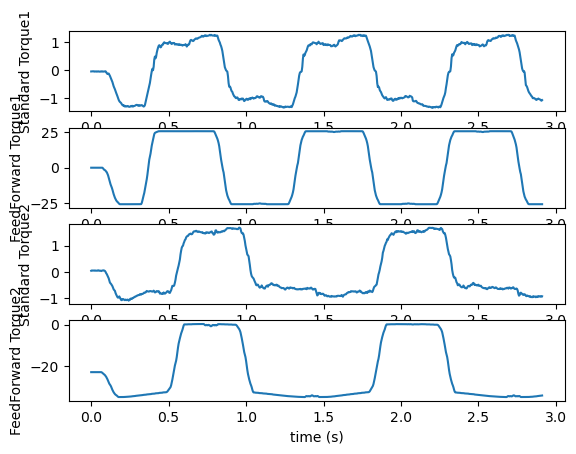

In [9]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
RMS_Value=pd.DataFrame(columns=columns)
Skewness_value = pd.DataFrame(columns=columns)
Kurtosis_value = pd.DataFrame(columns=columns)
Crest_factor = pd.DataFrame(columns=columns)
Energy = pd.DataFrame(columns=columns)
Stv = pd.DataFrame(columns=columns)
Variance = pd.DataFrame(columns=columns)
fig = plt.figure(figsize=(20,8))
fig, (x1, x2, x3, x4) = plt.subplots(4, 1)
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    with ZipFile(route) as File:
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                #Set the index
                date = header['date_time']
                i = date.date()
                #Read data
                data = read_data(f)
                mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                if ax1 in file:
                    d1 = series.standardized_torque()
                    time_index = series.time_index
                    x1.plot(time_index,d1)
                    x1.set_ylabel('Standard Torque1')
                    x2.plot(time_index,series.torque_ff)
                    x2.set_xlabel('time (s)')
                    x2.set_ylabel('FeedForward Torque1')
                elif ax2 in file:
                    d2 = series.standardized_torque()
                    time_index = series.time_index
                    x3.plot(time_index,d2)
                    x3.set_ylabel('Standard Torque2')
                    x4.plot(time_index,series.torque_ff)
                    x4.set_xlabel('time (s)')
                    x4.set_ylabel('FeedForward Torque2')
    break
                    

# Compute the cross-correlation in time-domain

In [71]:
file_path = '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip'

with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                refenerce1 = series.torque 
            elif ax2 in file:
                refenerce2 = series.torque                    
            elif ax3 in file:
                refenerce3 = series.torque
            elif ax4 in file:
                refenerce4 = series.torque
            elif ax5 in file:
                refenerce5 = series.torque
            elif ax6 in file:
                refenerce6 = series.torque
refenerce1

array([-1.69291000e-01, -1.33902000e-01, -1.38939000e-01, -1.37231000e-01,
       -1.39562000e-01, -1.40678000e-01, -1.37802000e-01, -1.39786000e-01,
       -1.37093000e-01, -1.35549000e-01, -1.30990000e-01, -9.99910000e-02,
       -1.35191000e-01, -1.34080000e-01, -1.33376000e-01, -1.32887000e-01,
       -1.32513000e-01, -4.06500000e-03, -1.32574000e-01, -1.32001000e-01,
       -1.31582000e-01, -1.31245000e-01, -1.30951000e-01, -1.33773000e-01,
       -8.71476000e-01, -1.65926500e+00, -2.21640900e+00, -2.27035950e+00,
       -2.02587300e+00, -2.85451100e+00, -3.72716900e+00, -5.25309800e+00,
       -6.73061950e+00, -7.80994800e+00, -9.15439400e+00, -1.10538455e+01,
       -1.28811570e+01, -1.40235580e+01, -1.53832595e+01, -1.70778295e+01,
       -1.85390060e+01, -1.99892340e+01, -2.14368505e+01, -2.32633120e+01,
       -2.45005575e+01, -2.58196000e+01, -2.65101900e+01, -2.66831385e+01,
       -2.69293100e+01, -2.81776655e+01, -2.89358350e+01, -2.91008805e+01,
       -2.90016175e+01, -

<Figure size 2000x800 with 0 Axes>

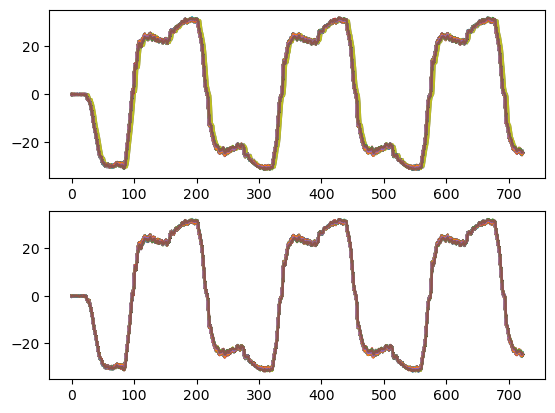

In [72]:
from scipy import signal
from scipy.fft import fft, ifft
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
columns=['axis1','axis2','axis3','axis4','axis5','axis6']

RMS_Value=pd.DataFrame(columns=columns)
Skewness_value = pd.DataFrame(columns=columns)
Kurtosis_value = pd.DataFrame(columns=columns)
Crest_factor = pd.DataFrame(columns=columns)
Energy = pd.DataFrame(columns=columns)
Stv = pd.DataFrame(columns=columns)
Variance = pd.DataFrame(columns=columns)
Shift = []
Shift1 = []
ref1 = refenerce1
fig = plt.figure(figsize=(20,8))
fig, (x1, x2) = plt.subplots(2, 1)
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    with ZipFile(route) as File:
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                #Set the index
                date = header['date_time']
                i = date.date()
                #Read data
                data = read_data(f)
                mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                if ax1 in file:                    
                    d1 = series.torque
                    x1.plot(d1)
                    corr = signal.correlate(ref1,d1)
#                     corr = np.max(corr)   
                    indx = np.argmax(corr, axis=0)
                    lags = signal.correlation_lags(len(ref1), len(d1))
                    Shift.append(lags[indx])
                    offset = lags[indx]
                    min_length = min(d1.size,ref1.size)-abs(offset)
                    d1_m, ref1_m = shift_signal(offset, min_length, d1, ref1)
                    x2.plot(d1_m)
                    corr1 = signal.correlate(ref1_m,d1_m)
#                     corr = np.max(corr)   
                    indx1 = np.argmax(corr1, axis=0)
                    lags1 = signal.correlation_lags(len(ref1_m), len(d1_m))
            
                    Shift1.append(lags1[indx1])
                    


In [64]:
ref1_m.shape
max(Shift1)


0

In [59]:
def shift_signal(offset, min_length, d, ref):    
    if offset > 0:
        d = d[:min_length] ;
        ref = ref[offset:offset+min_length-1];
    elif offset < 0:
        d = d[-offset:-offset+min_length-1];
        ref = ref[:min_length]
    return d,ref

In [48]:
corr /= np.max(corr)
corr

array([8.79924693e-06, 1.75045840e-05, 2.03136800e-05, ...,
       2.66514838e-05, 1.83397422e-05, 1.01186559e-05])

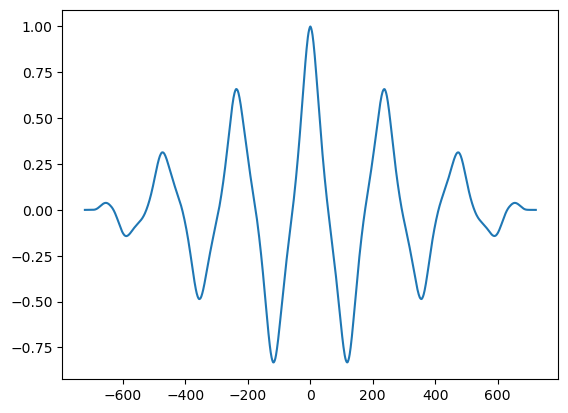

In [50]:
lags
plt.plot(lags, corr)

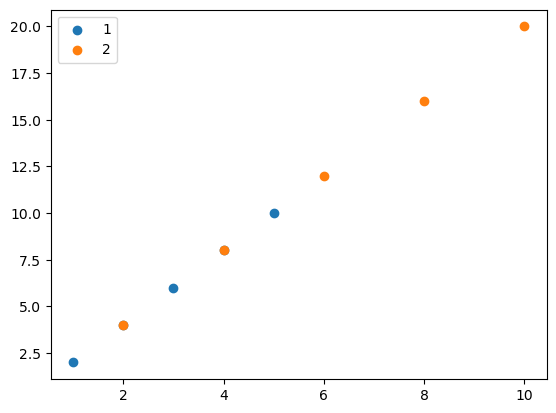

In [4]:
import matplotlib.pyplot as plt# 假设有两组数据，分别是 x 和 y
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]
 
# 绘制散点图
plt.scatter(x, y, label='1')
 
# 再来一组数据
a = [2, 4, 6, 8, 10]
b = [4, 8, 12, 16, 20]
 
# 绘制另一组数据的散点图
plt.scatter(a, b, label='2')
 
# 添加图例
plt.legend()
 
# 显示图像
plt.show()


# Get the reference point

In [65]:
def find_reference_point(data):
    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
    ref = series.standardized_torque()
    mean_value = series.torque.mean()
    stv = series.torque.std(ddof=0)
    return ref, mean_value, stv
    

In [66]:
file_path = '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip'

with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = find_reference_point(data)
                mean1 
            elif ax2 in file:
                ref2,mean2,stv2 = find_reference_point(data)                    
            elif ax3 in file:
                ref3,mean3,stv3 = find_reference_point(data)
            elif ax4 in file:
                ref4,mean4,stv4 = find_reference_point(data)
            elif ax5 in file:
                ref5,mean5,stv5 = find_reference_point(data)
            elif ax6 in file:
                ref6,mean6,stv6 = find_reference_point(data)


In [67]:
def standardized_torque(data,ref_mean,ref_stv):
    return (data - ref_mean) / ref_stv

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170918_180042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170918_MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_000033__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_060041__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_120031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_180311__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_000038__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_060026__MCC.zip


C:\Temp\ipykernel_18240\3088059257.py:35: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1-ref1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
C:\Temp\ipykernel_18240\3088059257.py:45: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2-ref2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
C:\Temp\ipykernel_18240\3088059257.py:55: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3-ref3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
C:\Temp\ipykernel_18240\3088059257.py:65: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extrac

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_120037__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_180212__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_000031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_120021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_180210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_000030__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_060025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_120023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_180220__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_050009__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_110016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_170202__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_230022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_050010__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_110016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_170201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_230024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171013_050022__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171104_180210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_000217__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_060358__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_120222__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_180423__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_000215__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_060223__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_120018__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_180215__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_000022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_060025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_120013__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_180209__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_000011__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_060205__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_120025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_180200__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171127_000012__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_120127__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_180313__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_000114__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_060122__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_120109__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_180304__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171220_000107__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171220_060114__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171220_180311__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180108_120050__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180108_180245__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_000046__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_060050__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_120048__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_180245__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_000043__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_060041__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_120034__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180130_120049__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180130_180255__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_000105__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_060108__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_180243__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_000104__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_060104__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_120058__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_180233__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180221_180211__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_000024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_060012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_120014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_180201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_000014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_060012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_120023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_180201__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180319_000020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180319_060006__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180319_120005__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180319_180148__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_000007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_060002__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_120004__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_180159__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180321_000020__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180409_110046__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180409_170210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180409_230020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_050016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_110043__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_170029__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_230211__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180411_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180411_110041__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180429_230017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180430_050023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180430_110029__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180430_170216__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180430_230026__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_050011__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_110018__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_170217__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_230024__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180520_230028__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_050035__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_110022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_170206__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_230017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_050024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_110021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_170216__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_230033__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180610_170157__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180610_230024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_050011__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_110008__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_170007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_230016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_050024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_110019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_170203__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_110019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_170017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_230201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_110012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_170207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_230023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180703_050021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180703_170208__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_110031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_170023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_230215__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180820_170032__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180820_230116__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180821_110034__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180821_170220__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180821_230037__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180822_110037__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_110013__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_170209__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_230019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180928_050007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180928_170207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180928_230005__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180929_050014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180929_110024__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_110042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_170228__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_230036__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181023_050043__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181023_110019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181023_170027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181024_050023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181024_110031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181024_170208__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190109_055946__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190109_115951__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190109_175952__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190110_000136__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190111_120045__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190111_180039__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190112_000223__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190114_134817__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190114_134835__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190203_000211__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190203_060031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190203_120207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190203_180014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190204_000017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190204_060015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190204_120022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190204_180207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190205_000028__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_060026__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_120021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_180027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190225_000225__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190225_060012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190225_120031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190225_180204__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190226_000021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190226_060011__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_060015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_120024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_180021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190319_000101__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190319_060021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190319_120025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190319_180300__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190320_000026__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190320_060014__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_045957__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_110054__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_170149__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_225959__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_050007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_110004__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_170149__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_230006__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190427_050005__MCC.zip
C:/Users/semihua/De

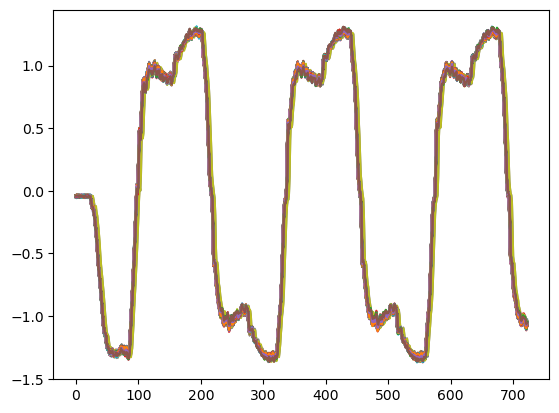

In [68]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
RMS_Value=pd.DataFrame(columns=columns)
Skewness_value = pd.DataFrame(columns=columns)
Kurtosis_value = pd.DataFrame(columns=columns)
Crest_factor = pd.DataFrame(columns=columns)
Energy = pd.DataFrame(columns=columns)
Stv = pd.DataFrame(columns=columns)
Variance = pd.DataFrame(columns=columns)
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    with ZipFile(route) as File:
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                #Set the index
                date = header['date_time']
                i = date.date()
                #Read data
                data = read_data(f)
                mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                if ax1 in file:
                # Extract features for axis1
                    d1 = standardized_torque(series.torque,mean1,stv1)
                    plt.plot(d1)
                    RMS_Value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
                    Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1-ref1)
                    Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1-ref1)
                    Energy.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d1-ref1)
                    Stv.loc[i, 'axis1'] = (d1-ref1).std(ddof=0)
                    Variance.loc[i, 'axis1'] = (d1-ref1).var()
                    Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1-ref1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
                elif ax2 in file:
                # Extract features for axis2
                    d2 = standardized_torque(series.torque,mean2,stv2)
                    RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
                    Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2-ref2)
                    Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2-ref2)
                    Energy.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d2-ref2)
                    Stv.loc[i, 'axis2'] = (d2-ref2).std(ddof=0)
                    Variance.loc[i, 'axis2'] = (d2-ref2).var()
                    Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2-ref2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
                elif ax3 in file:
                # Extract features for axis3
                    d3 = standardized_torque(series.torque,mean3,stv3)
                    RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
                    Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3-ref3)
                    Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3-ref3)
                    Stv.loc[i, 'axis3'] = (d3-ref3).std(ddof=0)
                    Variance.loc[i, 'axis3'] = (d3-ref3).var()
                    Energy.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d3-ref3)
                    Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3-ref3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
                elif ax4 in file:
                # Extract features for axis4
                    d4 = standardized_torque(series.torque,mean4,stv4)
                    RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4-ref4)
                    Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4-ref4)
                    Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4-ref4)
                    Energy.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d4-ref4)
                    Stv.loc[i, 'axis4'] = (d4-ref4).std(ddof=0)
                    Variance.loc[i, 'axis4'] = (d4-ref4).var()
                    Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4-ref4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4-ref4)
                elif ax5 in file:
                # Extract features for axis5
                    d5 = standardized_torque(series.torque,mean5,stv5)
                    RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5-ref5)
                    Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5-ref5)
                    Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5-ref5)
                    Energy.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d5-ref5)
                    Stv.loc[i, 'axis5'] = (d5-ref5).std(ddof=0)
                    Variance.loc[i, 'axis5'] = (d5-ref5).var()
                    Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5-ref5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5-ref5)
                elif ax6 in file:
                # Extract features for axis6
                    d6 = standardized_torque(series.torque,mean6,stv6)
                    RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6-ref6)
                    Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6-ref6)
                    Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6-ref6)
                    Energy.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d6-ref6)
                    Stv.loc[i, 'axis6'] = (d6-ref6).std(ddof=0)
                    Variance.loc[i, 'axis6'] = (d6-ref6).var()
                    Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6-ref6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6-ref6)

               

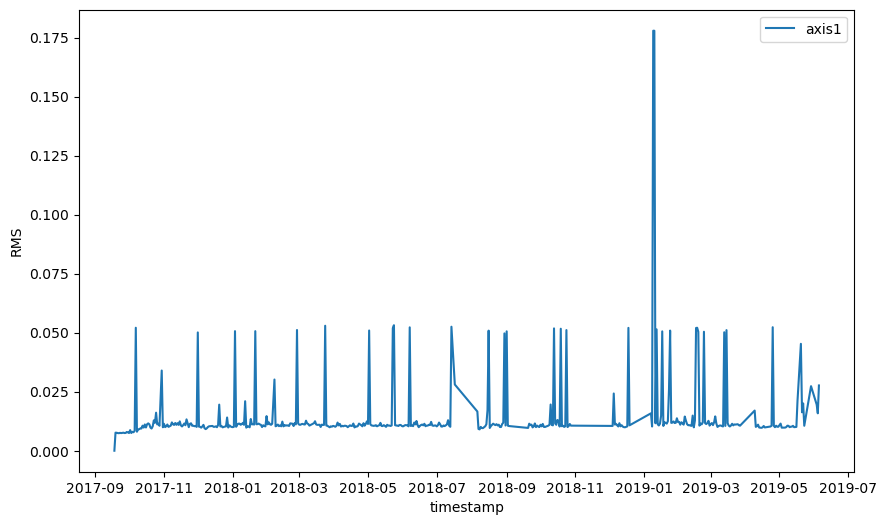

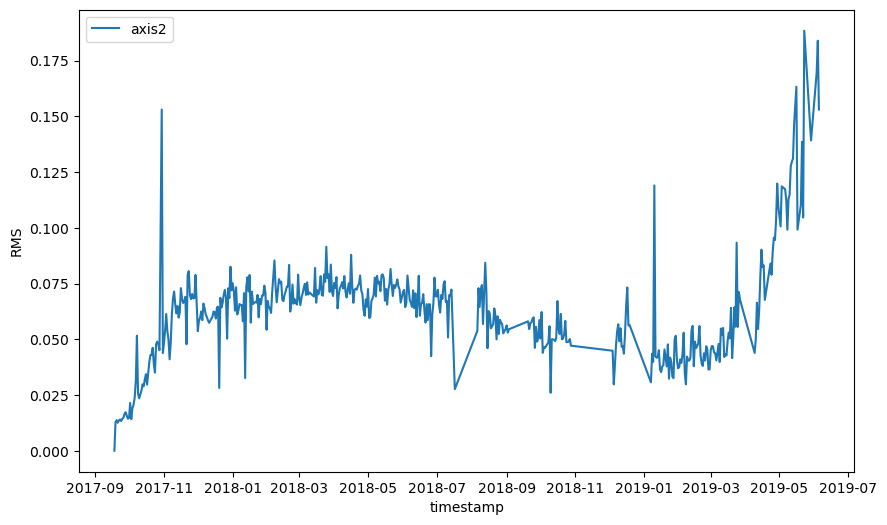

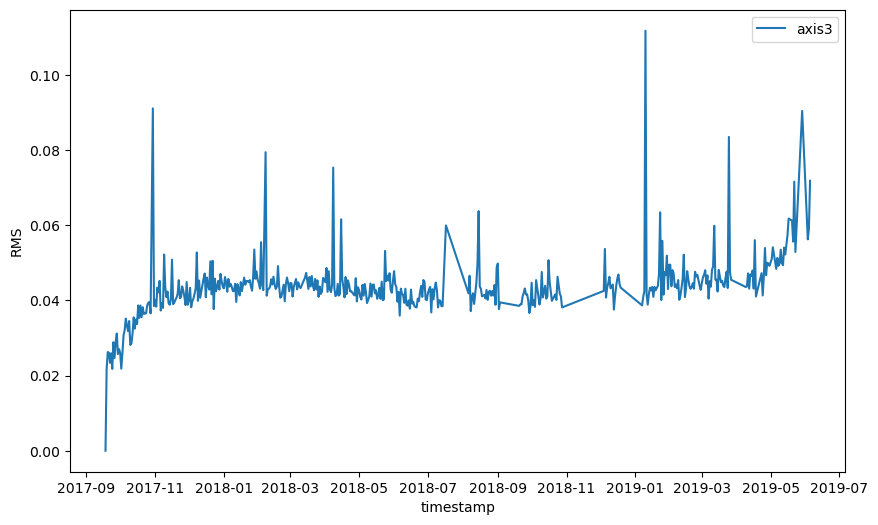

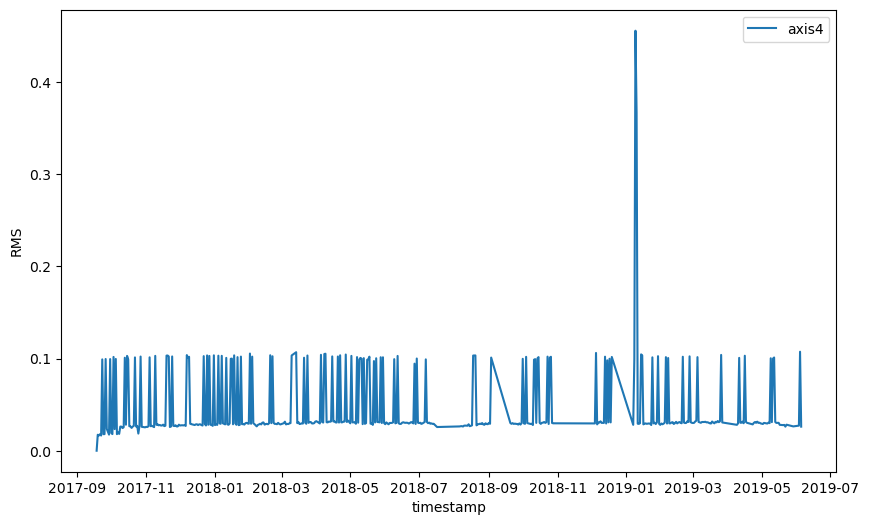

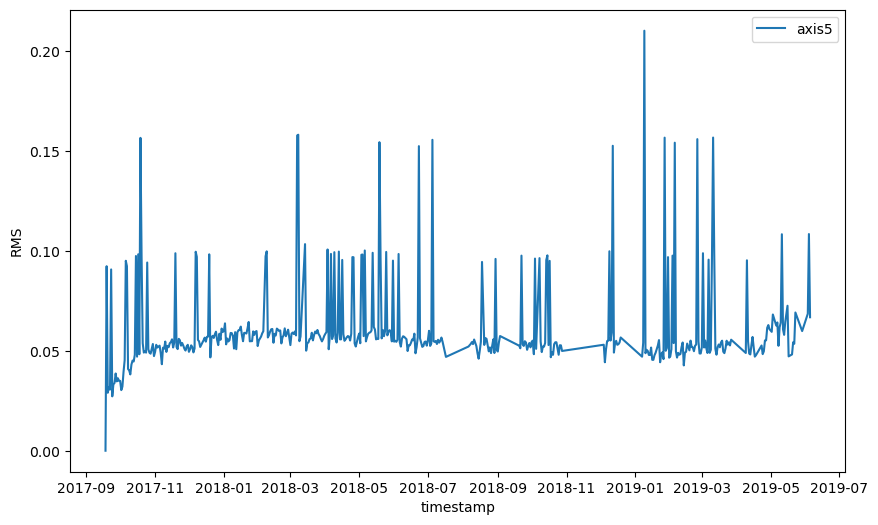

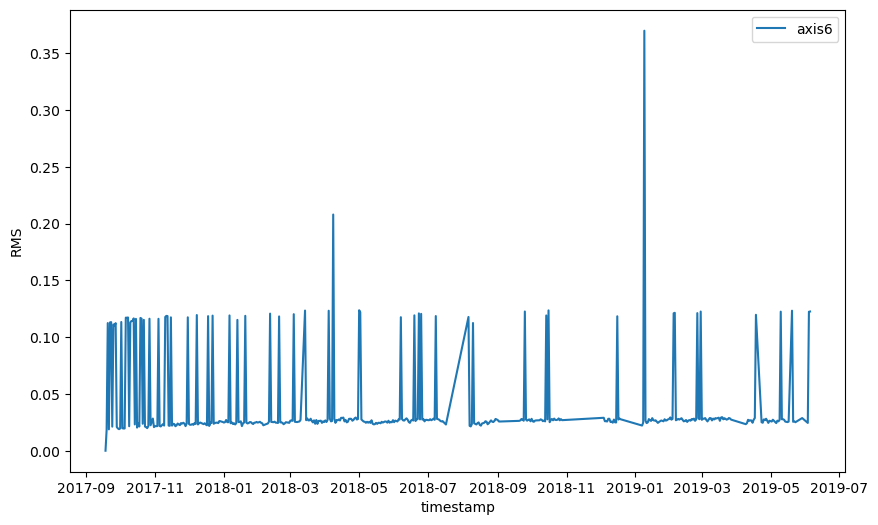

In [69]:
for i in columns:
    RMS_Value.plot(y=i, figsize=(10,6),xlabel='timestamp', ylabel='RMS')

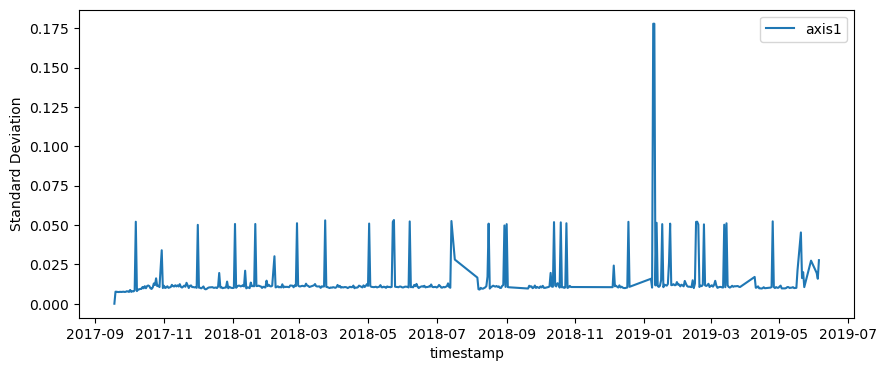

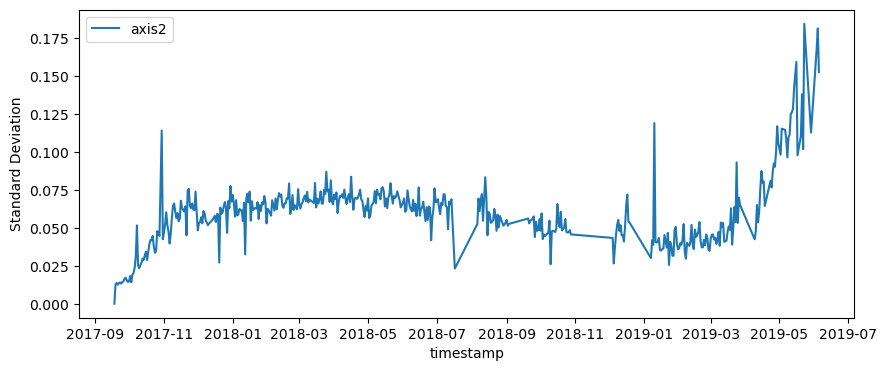

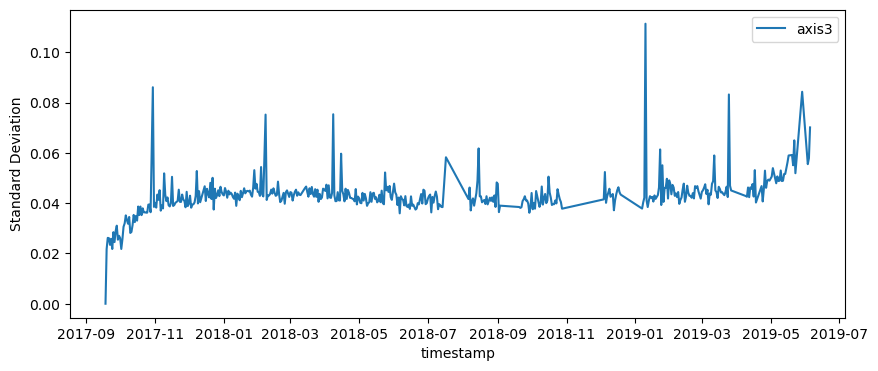

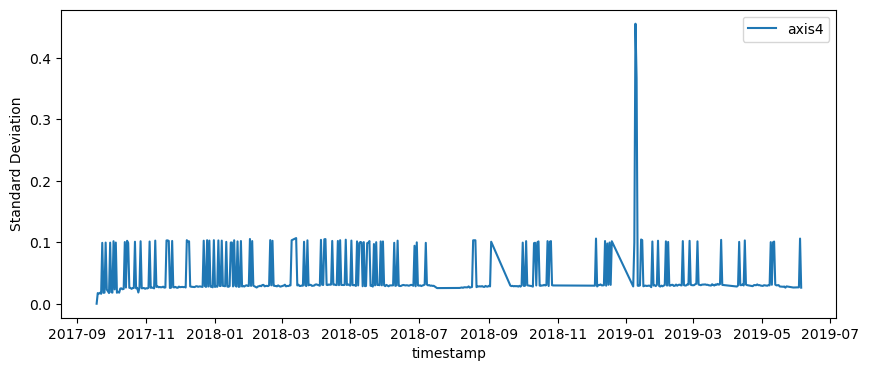

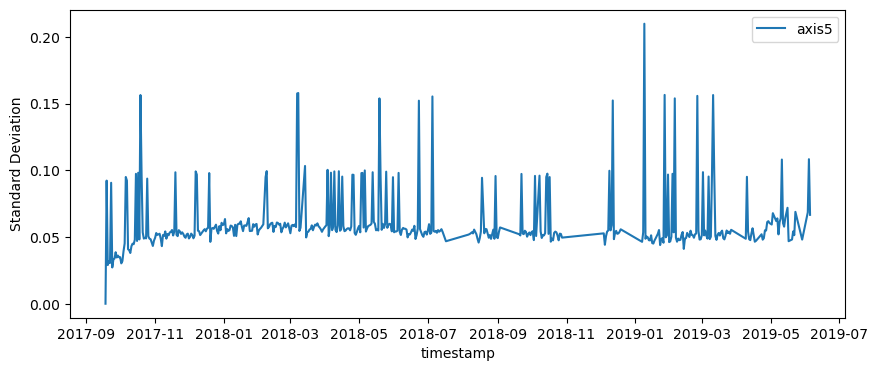

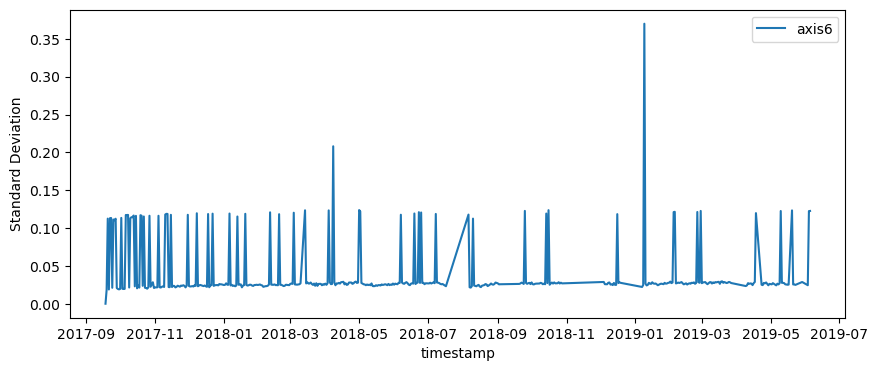

In [90]:
for i in columns:
    Stv.plot(y=i, figsize=(10,4),xlabel='timestamp', ylabel='Standard Deviation')

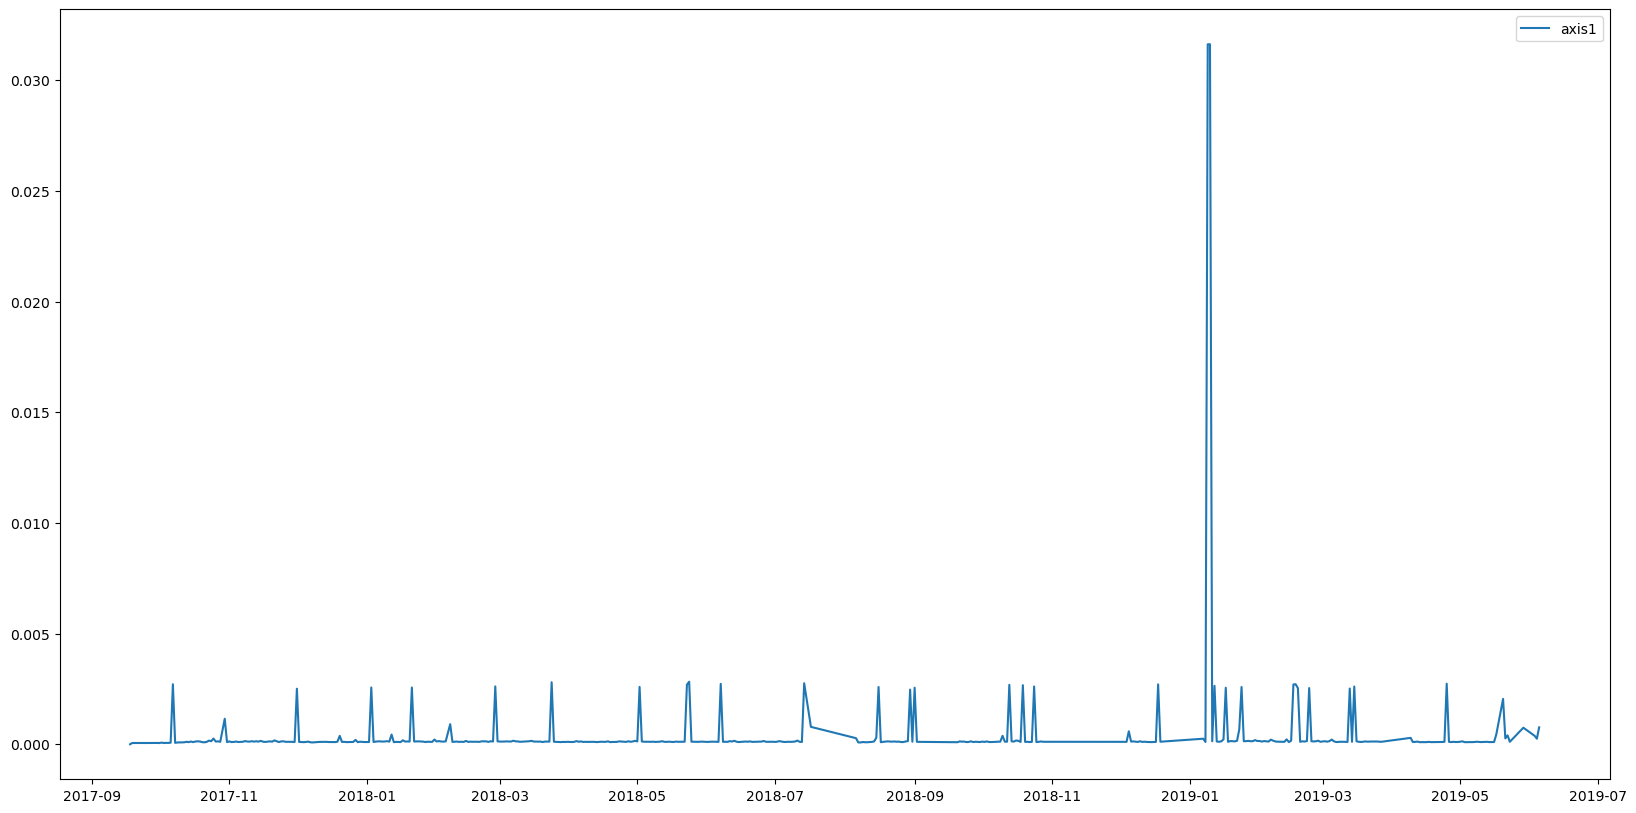

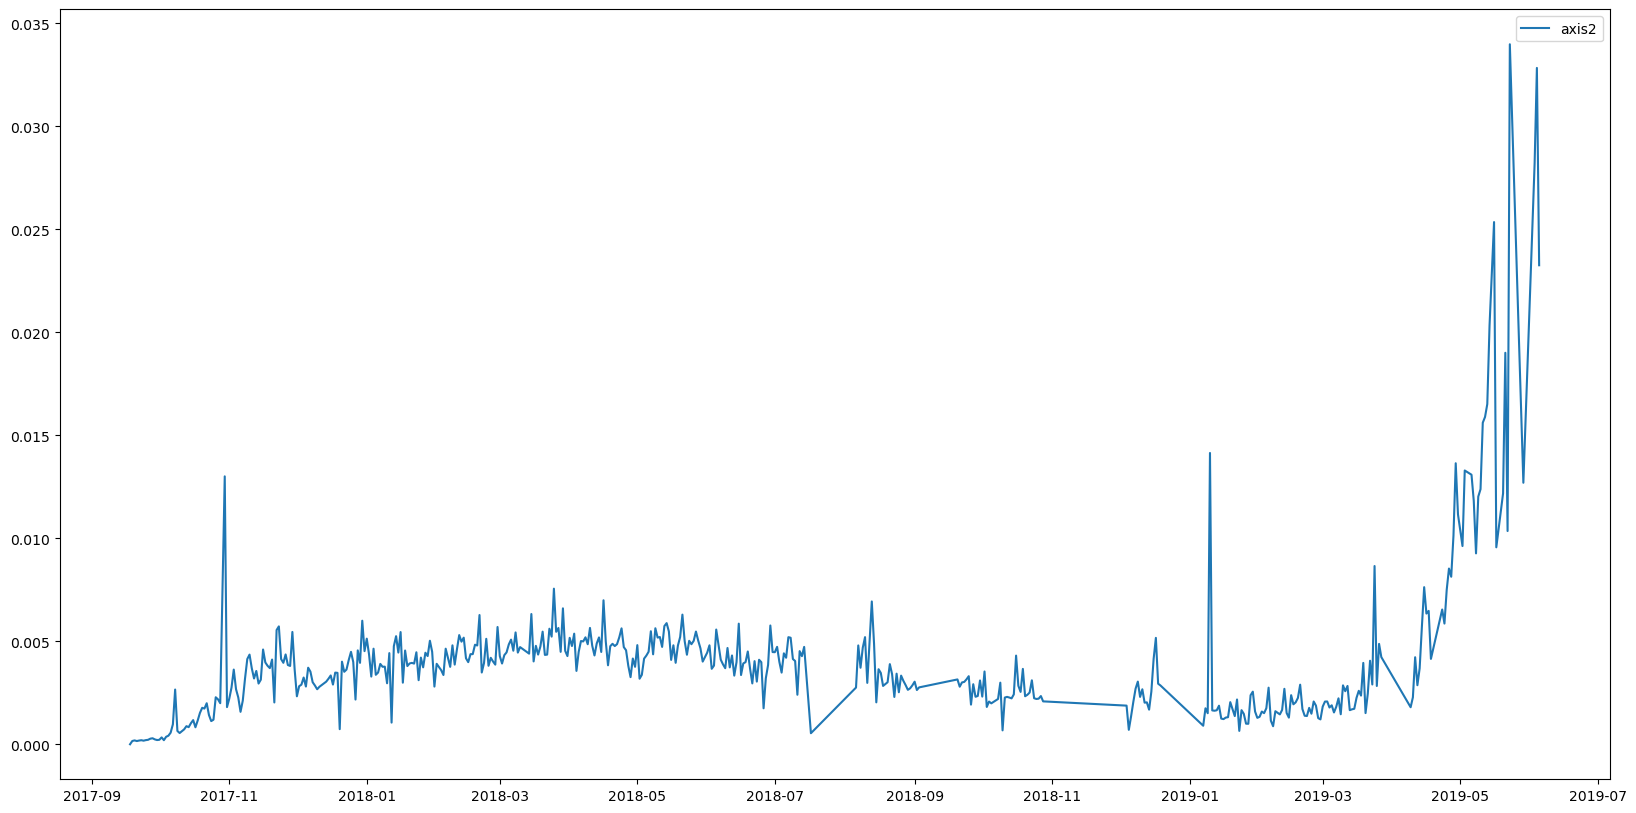

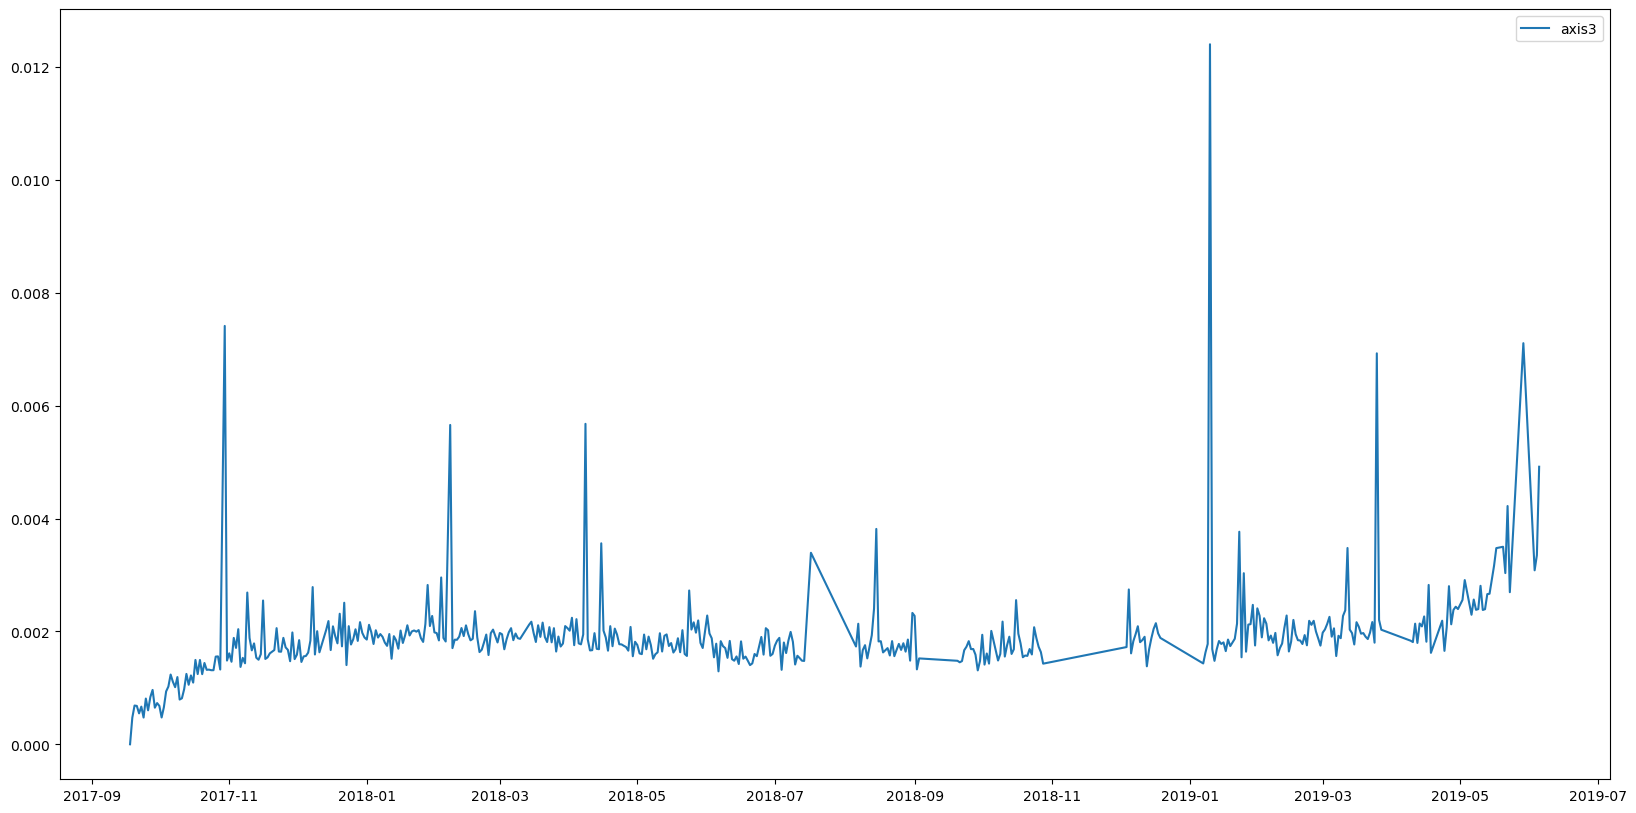

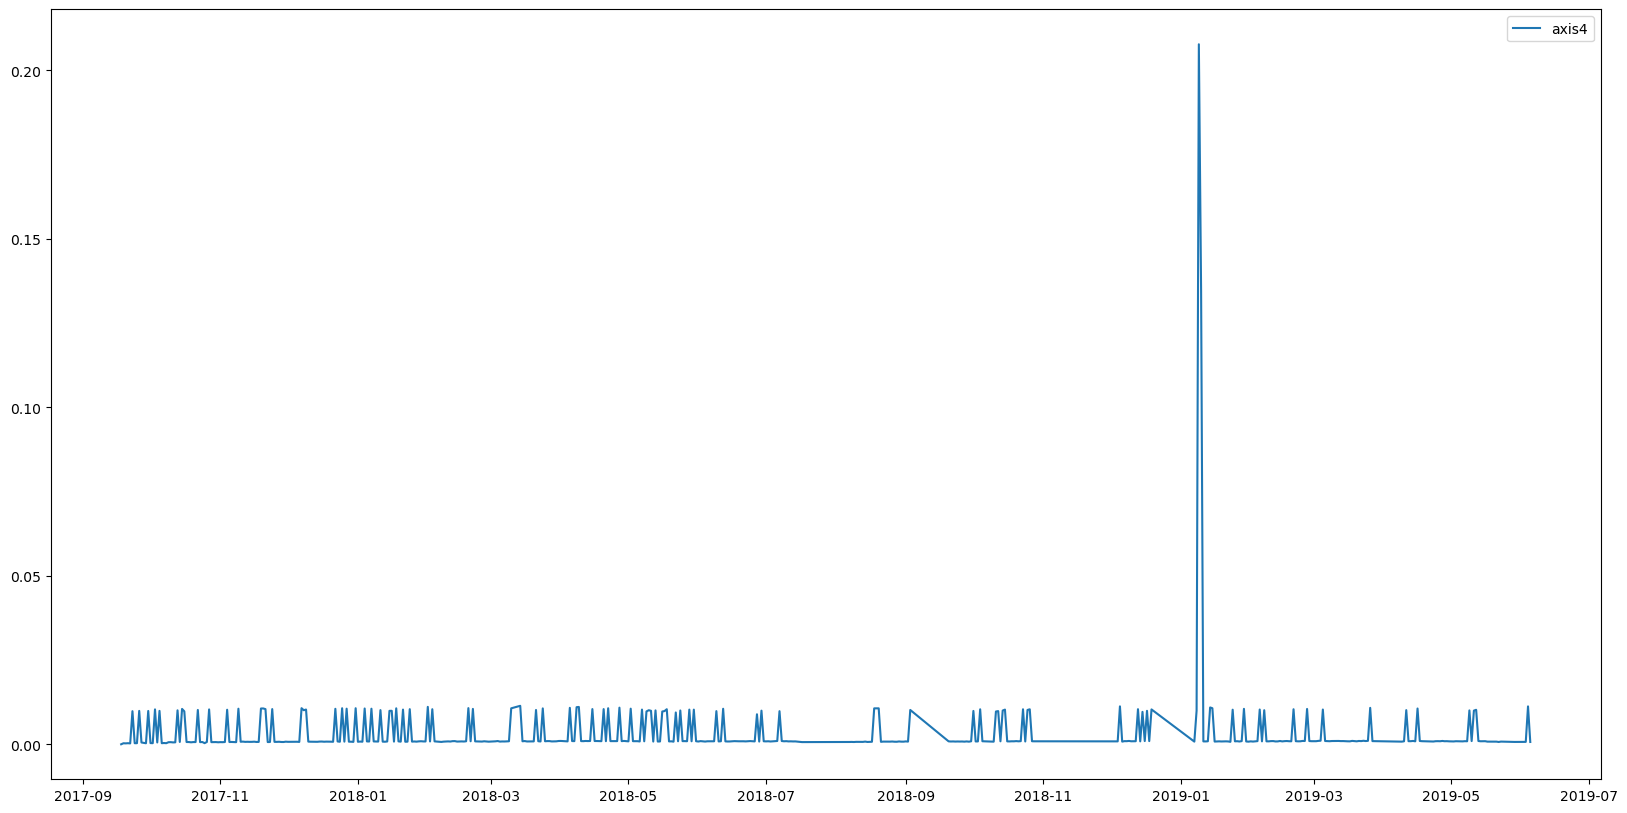

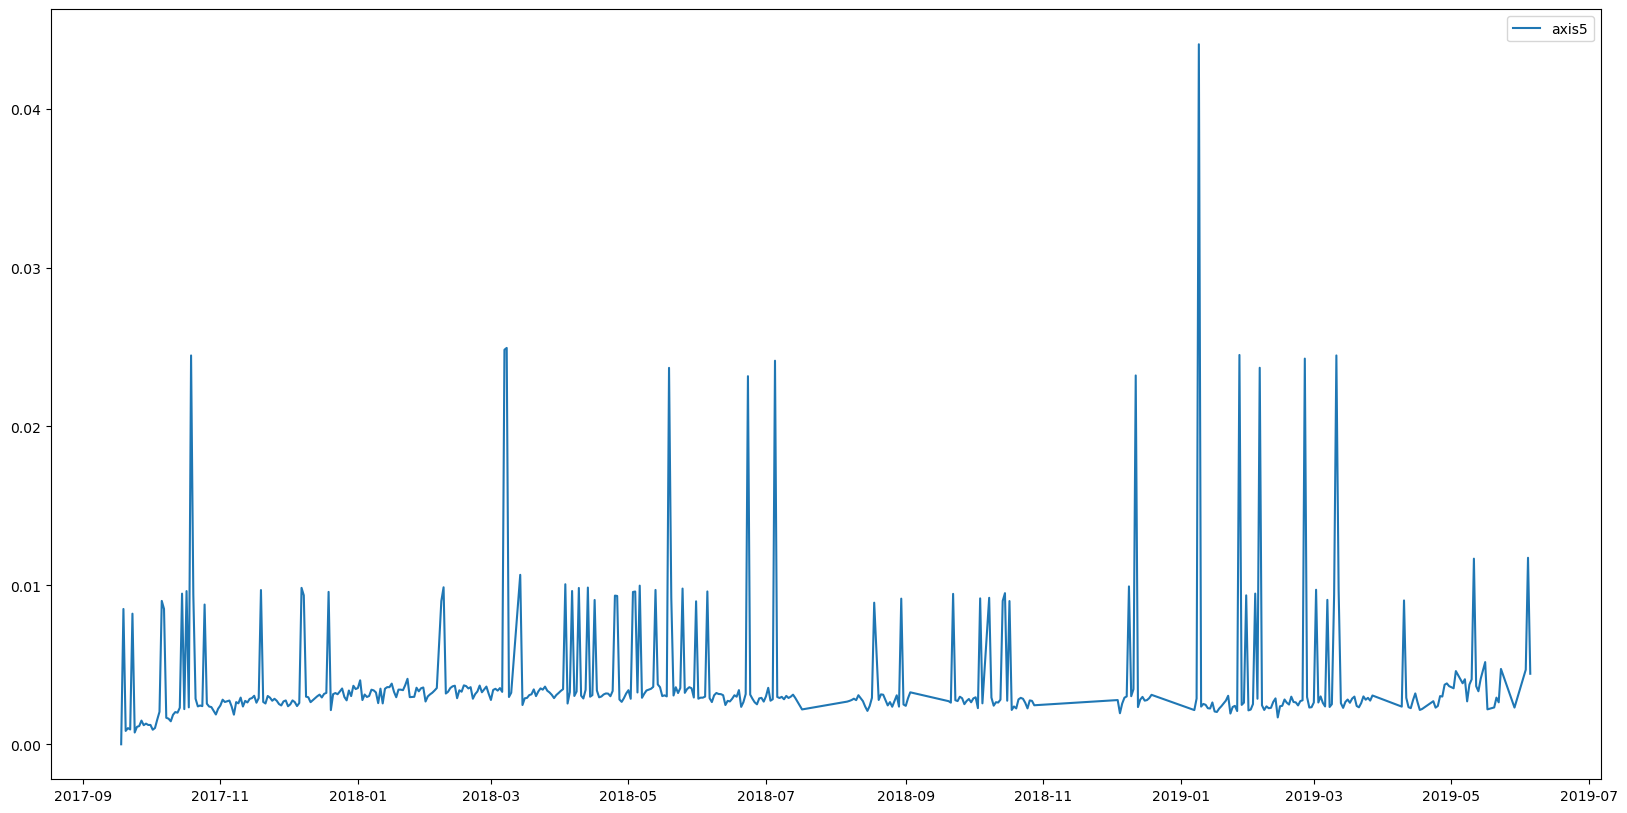

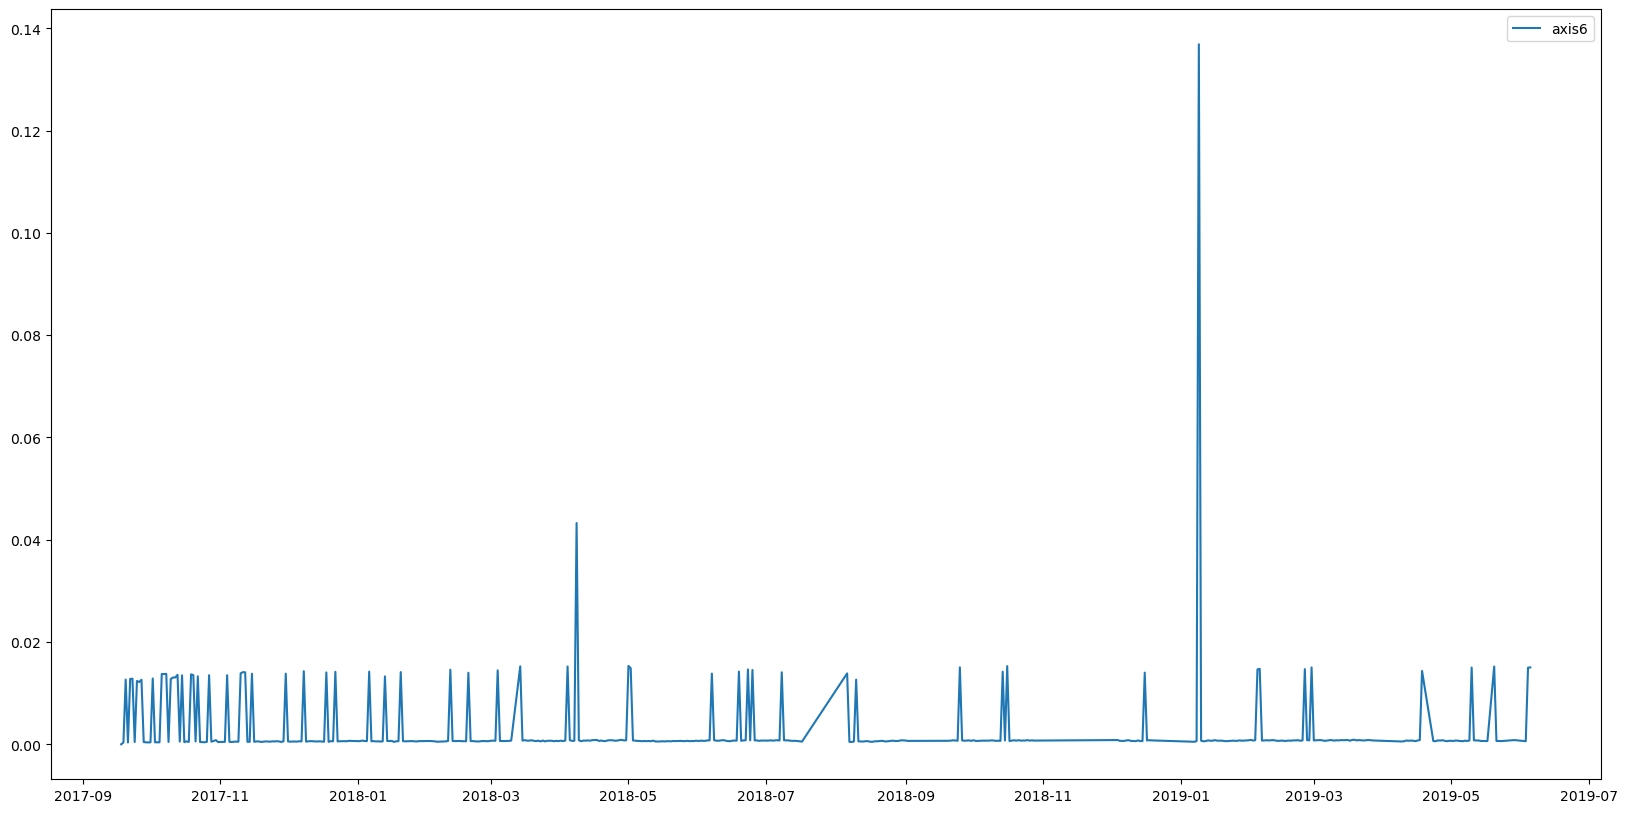

In [91]:
for i in columns:
    Variance.plot(y=i, figsize=(20,10))


In [ ]:
for i in columns:
    Variance.plot(y=i, figsize=(20,10))

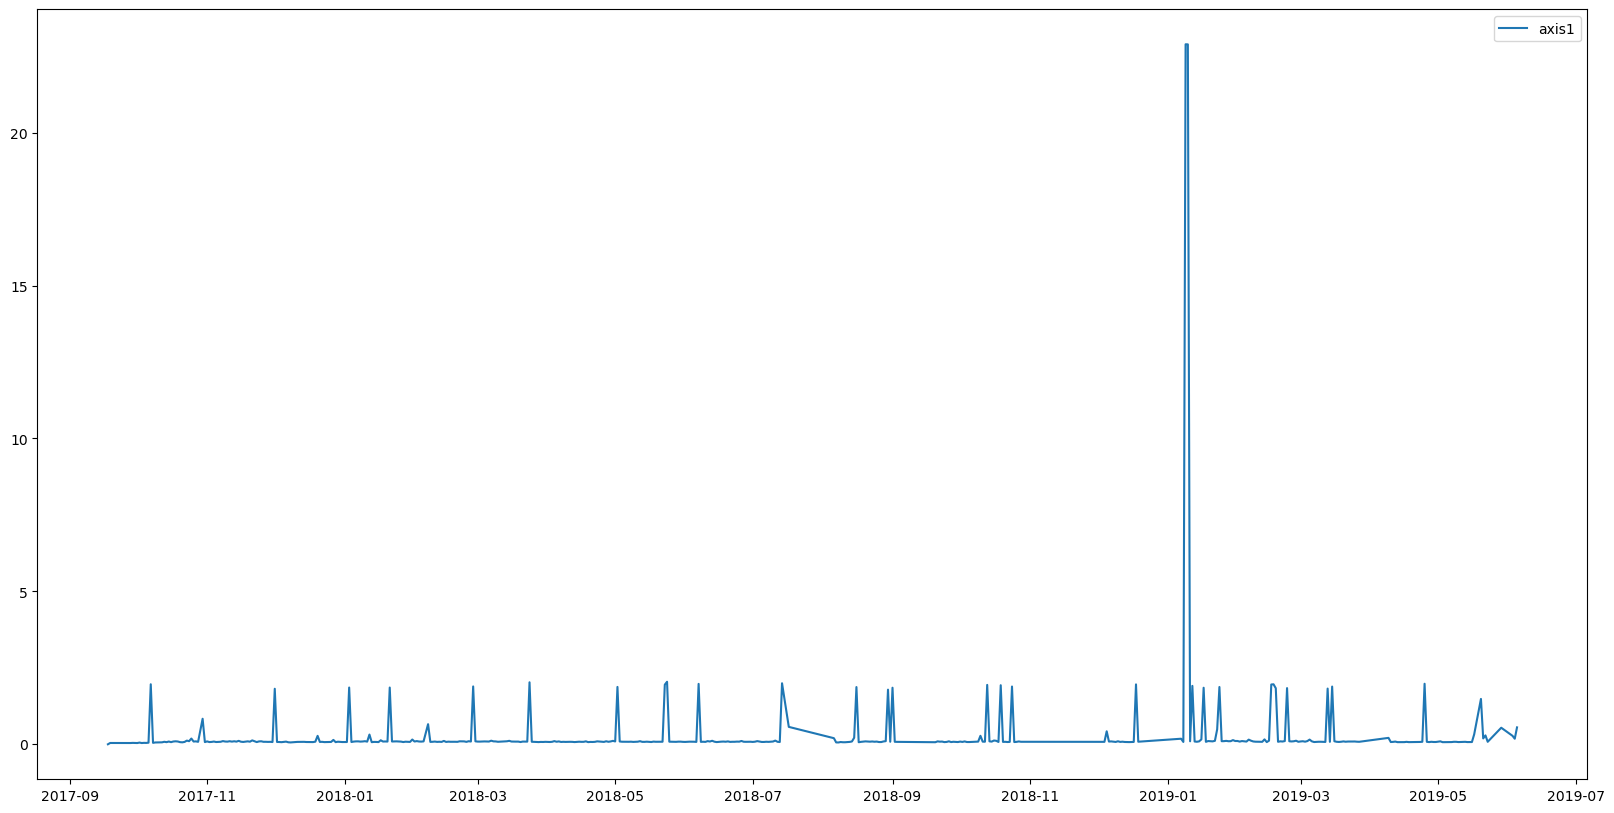

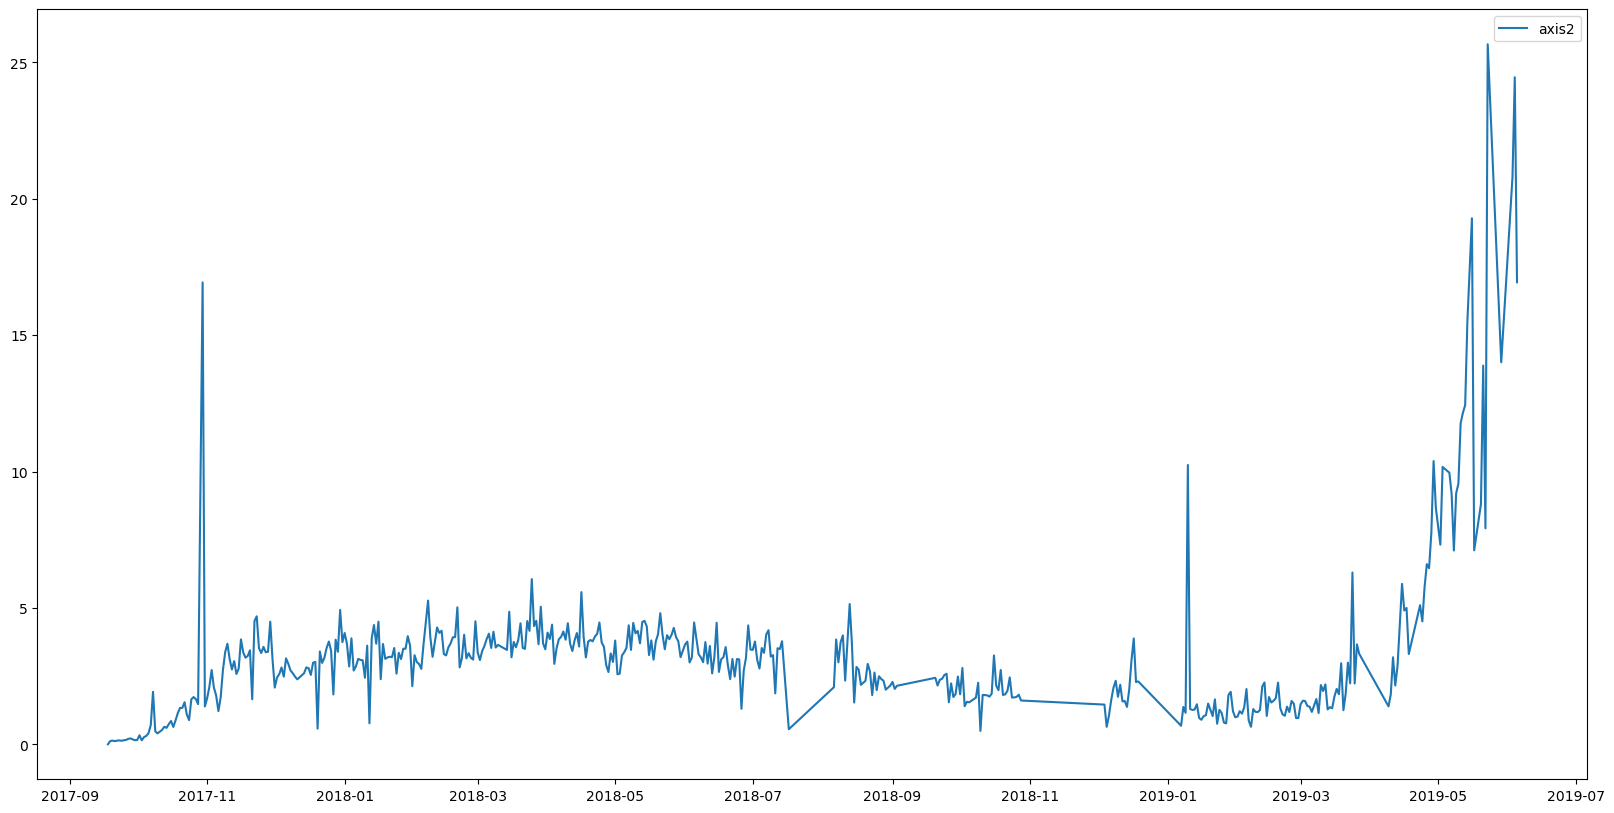

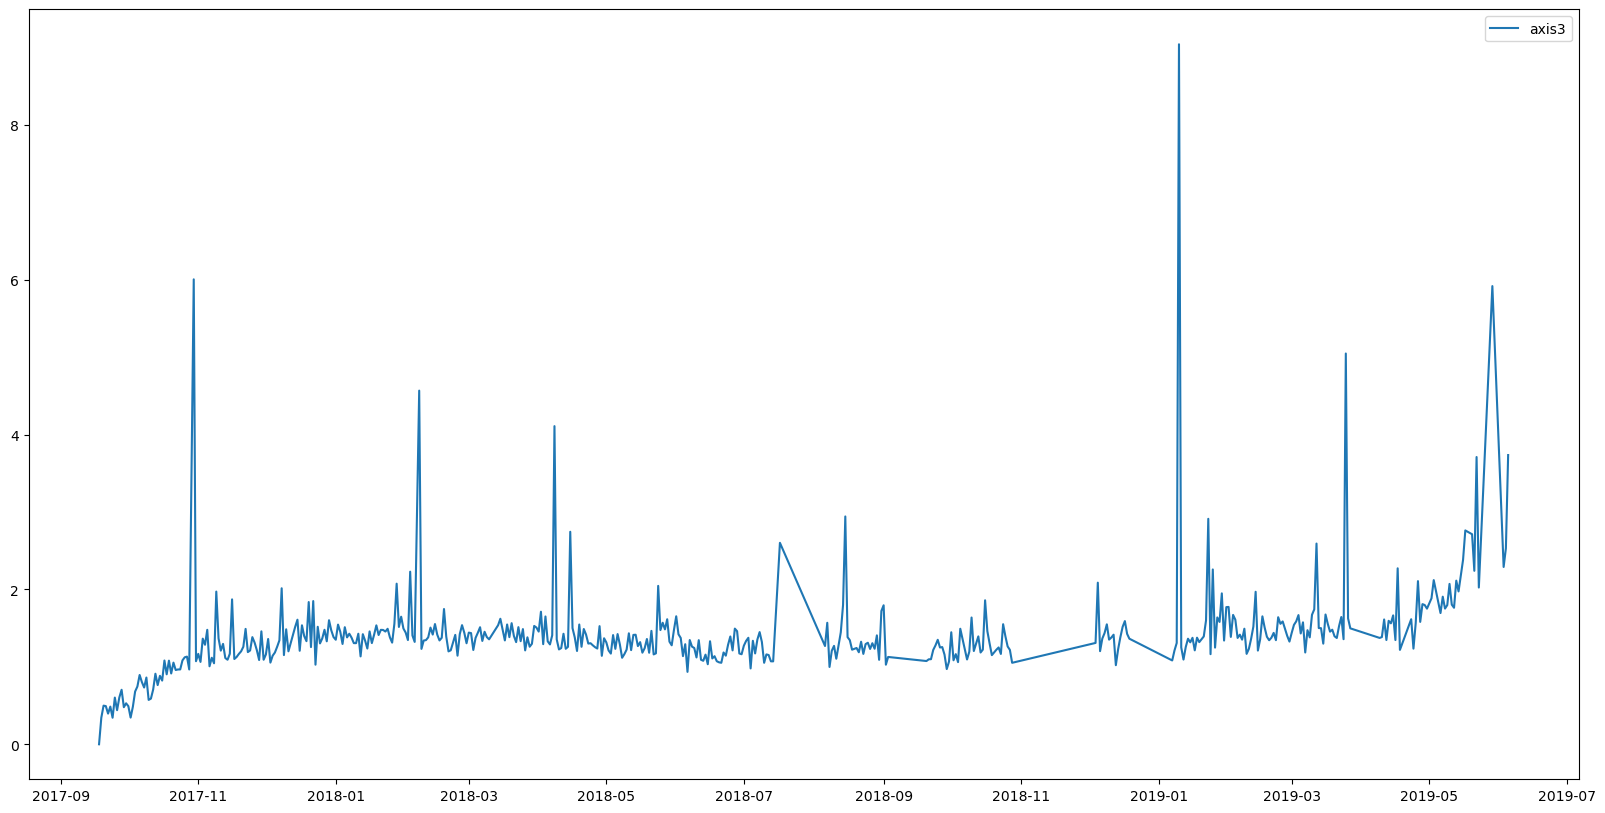

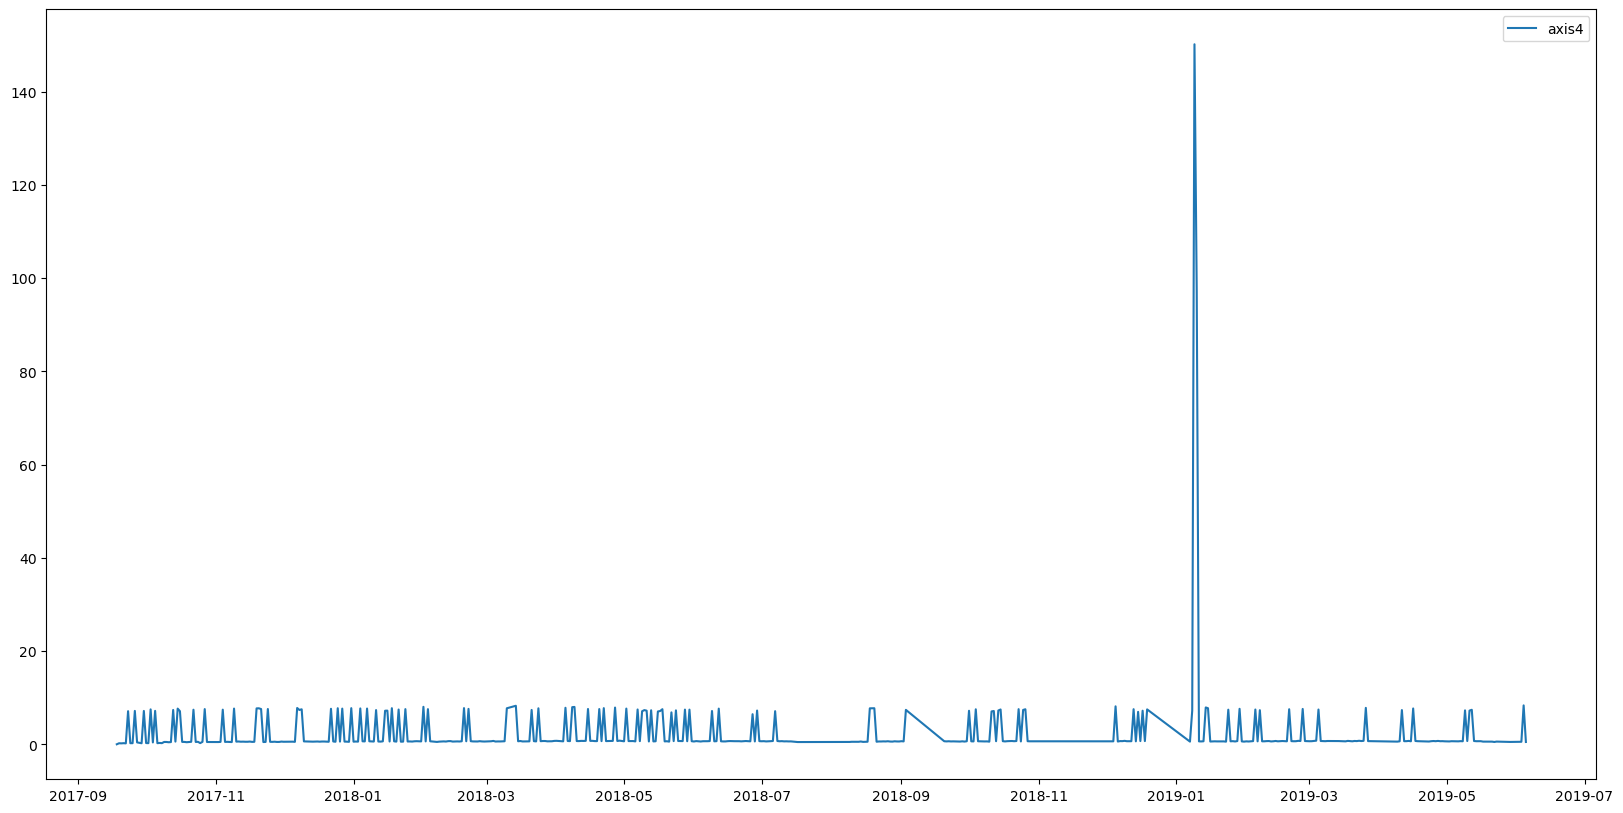

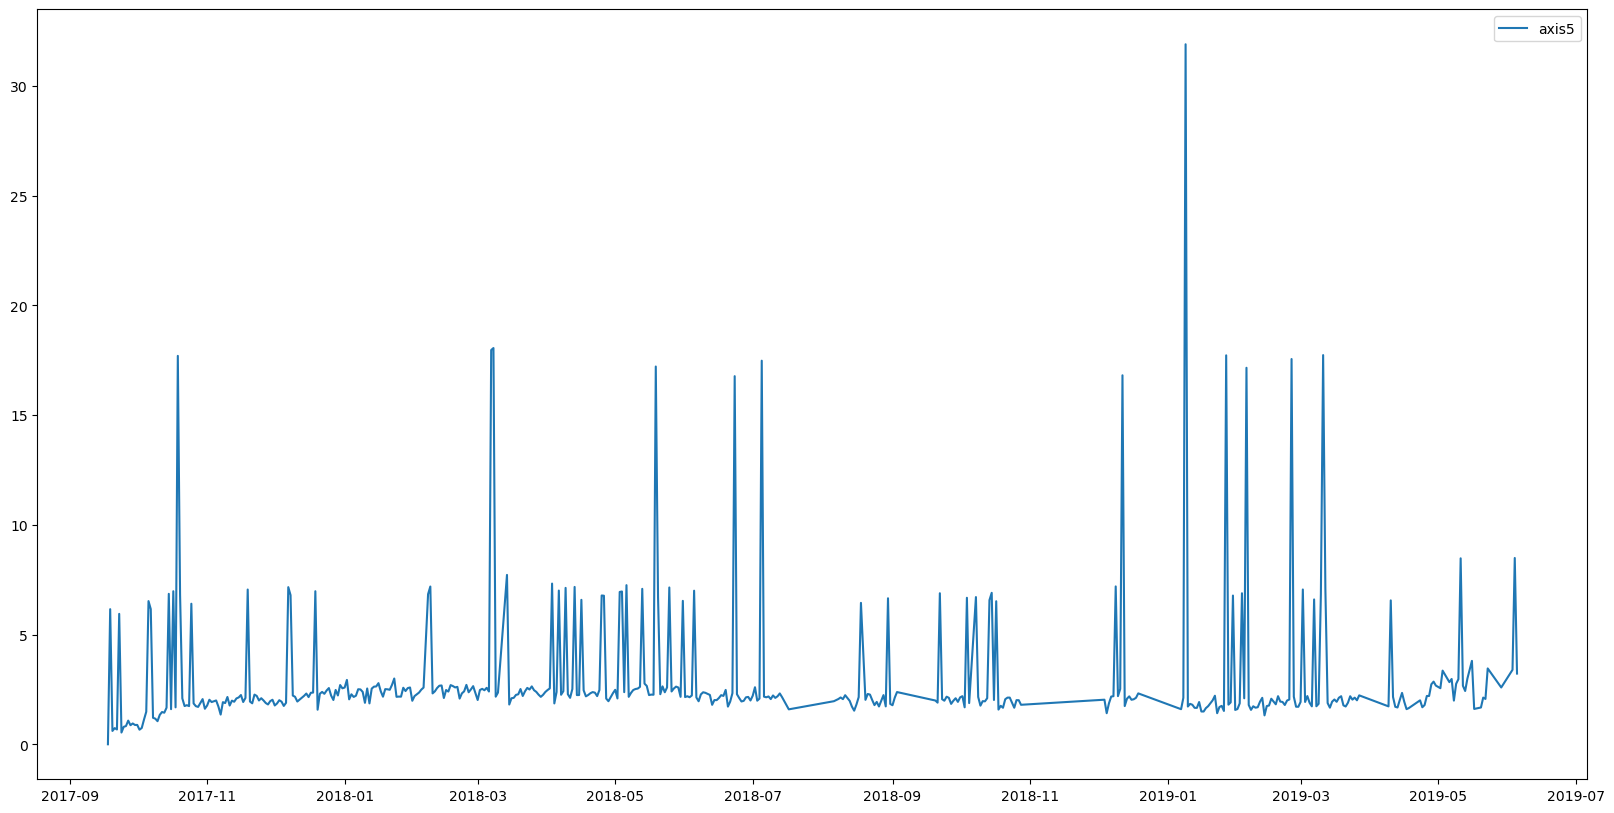

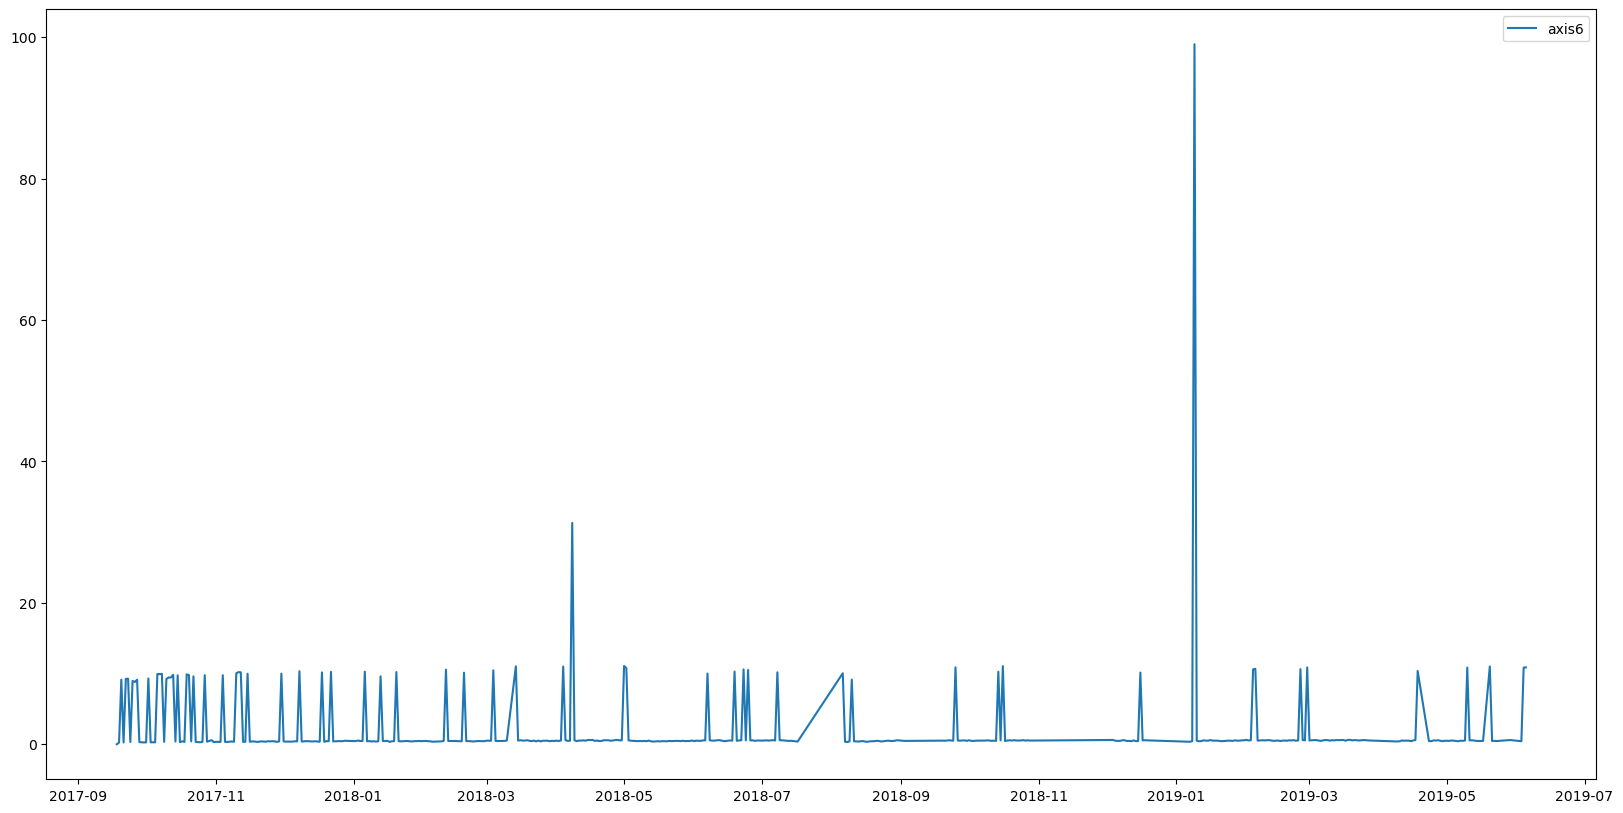

In [92]:
for i in columns:
    Energy.plot(y=i, figsize=(20,10))

In [94]:
# for i in columns:
#     Skewness_value.plot(y=i, figsize=(20,10))


In [95]:
# for i in columns:
#     Kurtosis_value.plot(y=i, figsize=(20,10))

In [96]:
# for i in columns:
#     Crest_factor.plot(y=i, figsize=(20,10))


# Features for each axis

In [20]:
feature_axis1 = pd.concat([RMS_Value['axis1'],Skewness_value['axis1'],Kurtosis_value['axis1'],Stv['axis1'],Crest_factor['axis1'],Energy['axis1']],axis=1)
feature_axis1.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df1 = feature_axis1.drop(index=feature_axis1.index[0])
df1

,RMS,Skewness,Kurtosis,Stv,Crest_factor,Energy
2017-09-19,0.005251,0.044248,-0.150898,0.003618,3.014838,0.019937
2017-09-20,0.005337,0.034276,-0.032943,0.003057,2.481527,0.020596
2017-09-21,0.004315,0.089211,0.048127,0.002867,3.24202,0.01346
2017-09-22,0.003501,0.042439,0.118715,0.003057,3.228198,0.008864
2017-09-23,0.00403,0.05229,-0.210947,0.00312,2.888469,0.011745
...,...,...,...,...,...,...
2019-05-23,0.004399,0.205751,-0.221517,0.004308,3.424954,0.013993
2019-05-29,0.012233,0.202552,-0.570122,0.012207,2.873678,0.10819
2019-06-03,0.008896,0.087342,-0.487487,0.008827,2.942788,0.057219
2019-06-04,0.00707,0.079199,-0.206406,0.006897,3.080134,0.036141


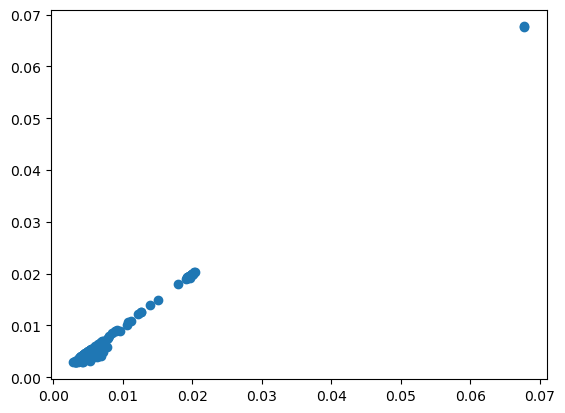

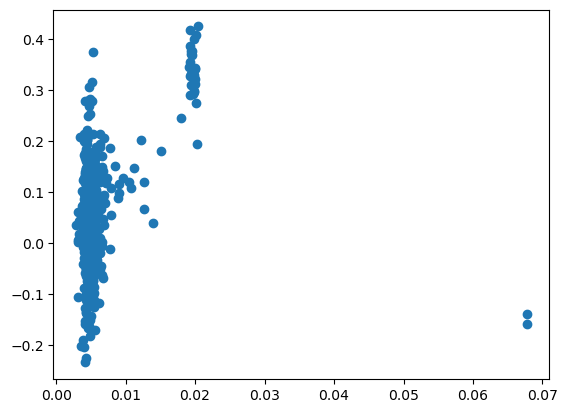

In [21]:
plt.scatter(df1['RMS'],df1['Stv'])
plt.show()
plt.scatter(df1['RMS'],df1['Skewness'])

In [22]:
feature_axis2 = pd.concat([RMS_Value['axis2'],Skewness_value['axis2'],Kurtosis_value['axis2'],Stv['axis2'],Crest_factor['axis2'],Energy['axis2']],axis=1)
feature_axis2.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df2 = feature_axis2.drop(index=feature_axis2.index[0])


In [23]:
feature_axis3 = pd.concat([RMS_Value['axis3'],Skewness_value['axis3'],Kurtosis_value['axis3'],Stv['axis3'],Crest_factor['axis3'],Energy['axis3']],axis=1)
feature_axis3.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df3 = feature_axis3.drop(index=feature_axis3.index[0])

In [24]:
feature_axis4 = pd.concat([RMS_Value['axis4'],Skewness_value['axis4'],Kurtosis_value['axis4'],Stv['axis4'],Crest_factor['axis4'],Energy['axis4']],axis=1)
feature_axis4.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df4 = feature_axis4.drop(index=feature_axis3.index[0])

In [25]:
feature_axis5 = pd.concat([RMS_Value['axis5'],Skewness_value['axis5'],Kurtosis_value['axis5'],Stv['axis5'],Crest_factor['axis5'],Energy['axis5']],axis=1)
feature_axis5.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df5 = feature_axis5.drop(index=feature_axis5.index[0])
df5

,RMS,Skewness,Kurtosis,Stv,Crest_factor,Energy
2017-09-19,0.02481,0.019406,1.697309,0.0246,3.982967,0.445044
2017-09-20,0.008761,0.059393,0.238528,0.008598,3.383435,0.055499
2017-09-21,0.010114,-0.235735,0.415331,0.009661,4.44138,0.073952
2017-09-22,0.009971,0.132416,0.150326,0.00992,2.990588,0.071883
2017-09-23,0.024103,-0.044722,1.930911,0.024078,4.390211,0.420039
...,...,...,...,...,...,...
2019-05-23,0.027957,0.53253,0.580891,0.021275,2.691049,0.565099
2019-05-29,0.017,0.584511,1.219108,0.015931,3.913701,0.208947
2019-06-03,0.028718,0.734397,0.999445,0.023067,2.510864,0.596257
2019-06-04,0.03113,0.301571,1.027898,0.029151,4.005579,0.700655


In [26]:
feature_axis6 = pd.concat([RMS_Value['axis6'],Skewness_value['axis6'],Kurtosis_value['axis6'],Stv['axis6'],Crest_factor['axis6'],Energy['axis6']],axis=1)
feature_axis6.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df6 = feature_axis6.drop(index=feature_axis6.index[0])
df6

,RMS,Skewness,Kurtosis,Stv,Crest_factor,Energy
2017-09-19,0.004015,0.178557,0.620124,0.003508,3.725304,0.011653
2017-09-20,0.020501,0.401172,7.308333,0.020381,5.366214,0.303868
2017-09-21,0.003665,0.019688,0.620211,0.003427,3.498431,0.009709
2017-09-22,0.020774,0.420651,7.4784,0.020507,5.641628,0.31201
2017-09-23,0.020597,0.384674,7.254864,0.02053,5.611709,0.306724
...,...,...,...,...,...,...
2019-05-23,0.005496,0.03774,0.997877,0.004571,3.235092,0.021838
2019-05-29,0.007532,-0.271721,2.083233,0.006179,3.640896,0.041012
2019-06-03,0.005009,0.223228,2.212812,0.004436,4.181497,0.018138
2019-06-04,0.022465,0.334116,7.203424,0.022145,5.731966,0.364894


In [27]:
from sklearn.cluster import KMeans

# Clustering between two features (each axis) 

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


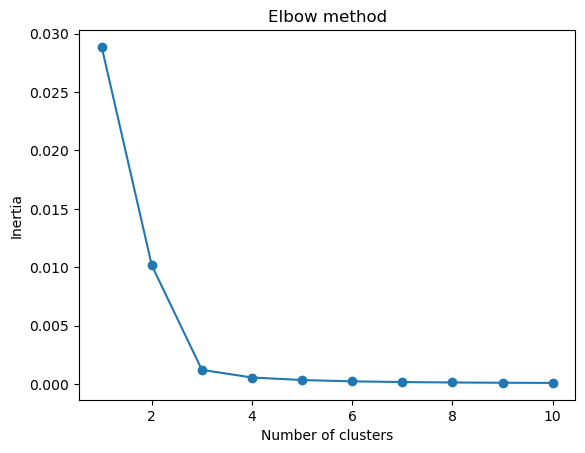

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0]


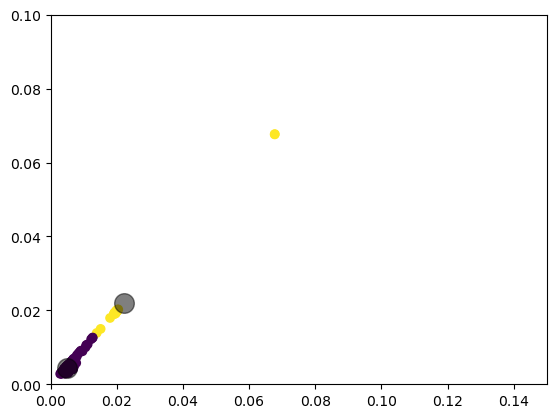

In [71]:
data = df1[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


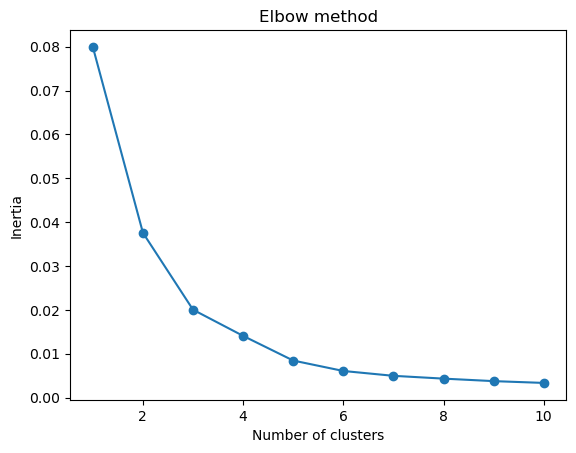

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]


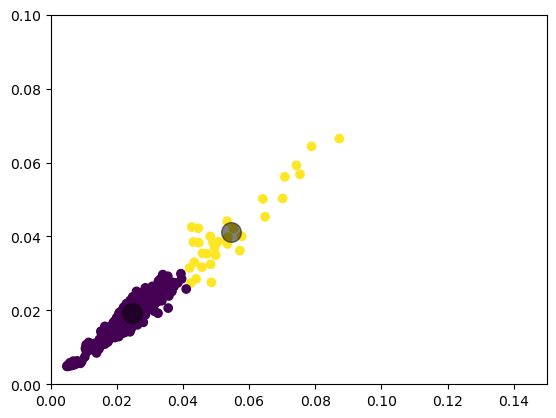

In [66]:
data = df2[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


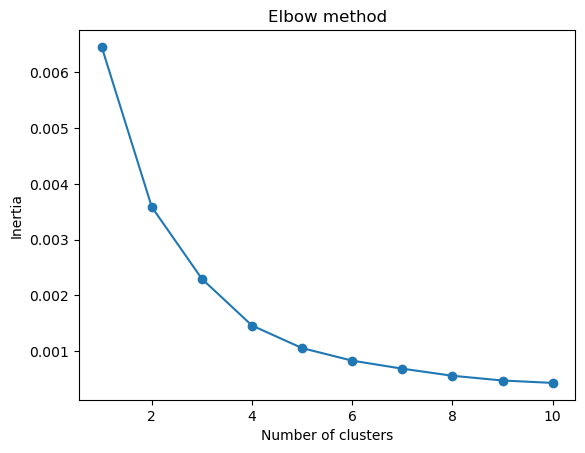

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0
 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]


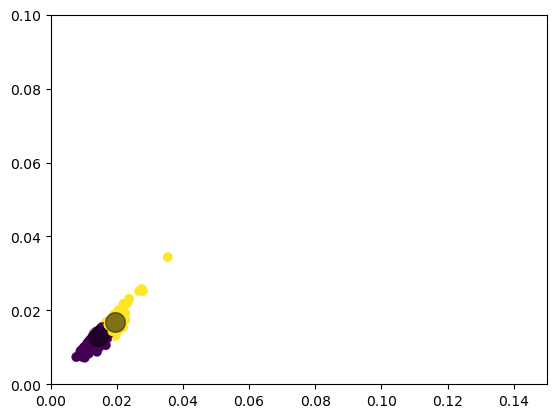

In [67]:
data = df3[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


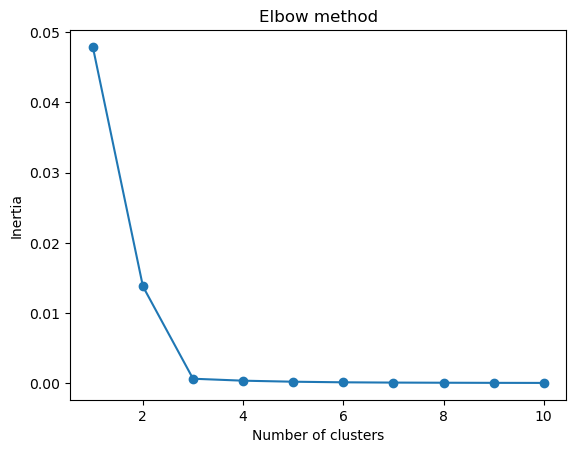

[0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0]


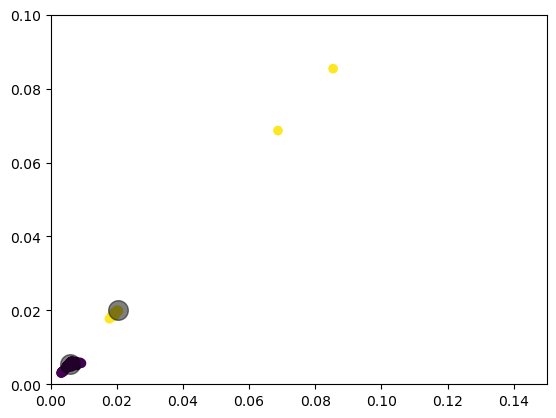

In [68]:
data = df4[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


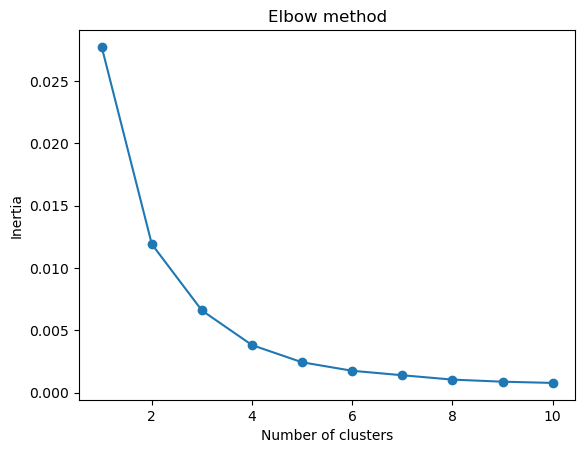

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 0 1]


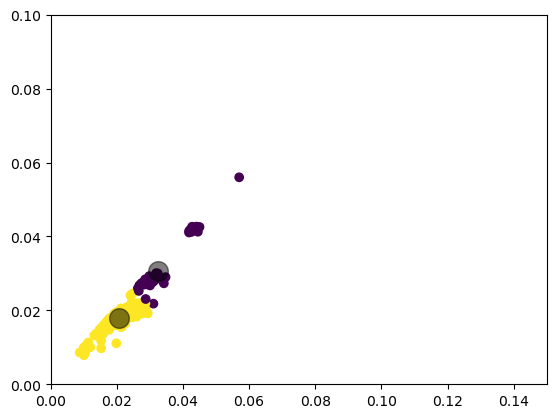

In [69]:
data = df5[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


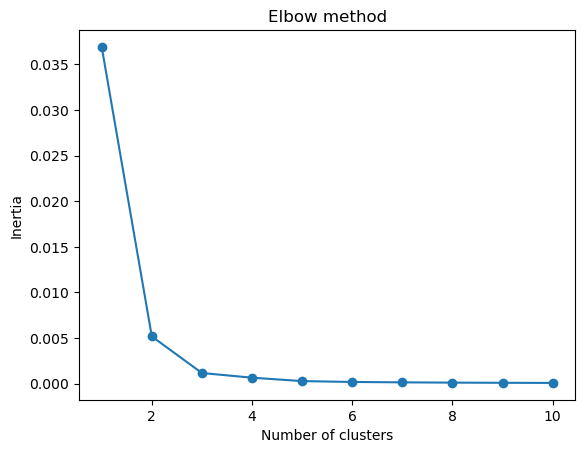

[0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 1]


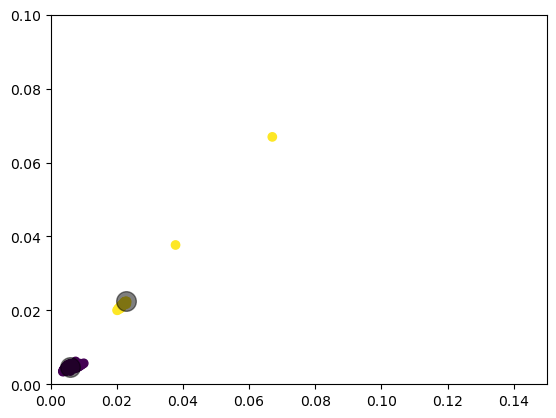

In [70]:
data = df6[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [34]:
feature = pd.concat([df1[['RMS','Stv']],df2[['RMS','Stv']],df3[['RMS','Stv']],df4[['RMS','Stv']],df5[['RMS','Stv']],df6[['RMS','Stv']]], axis=0)
feature

,RMS,Stv
2017-09-19,0.005251,0.003618
2017-09-20,0.005337,0.003057
2017-09-21,0.004315,0.002867
2017-09-22,0.003501,0.003057
2017-09-23,0.00403,0.00312
...,...,...
2019-05-23,0.005496,0.004571
2019-05-29,0.007532,0.006179
2019-06-03,0.005009,0.004436
2019-06-04,0.022465,0.022145


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


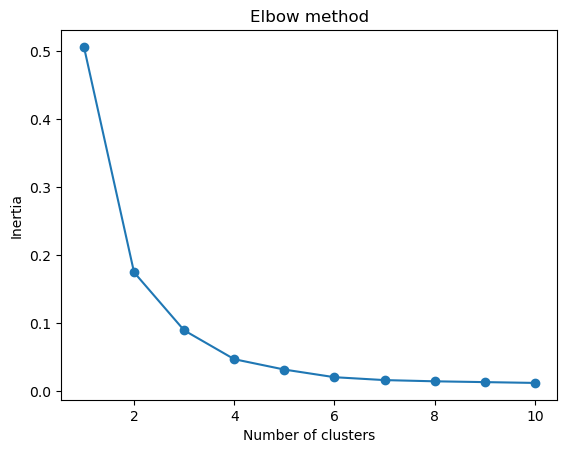

[0 0 0 ... 0 1 1]


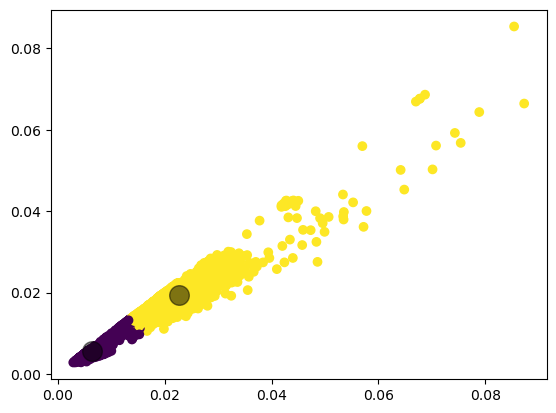

In [35]:
pd.set_option('max_colwidth',100)
inertias = []

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(feature)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(feature)

plt.scatter(feature['RMS'], feature['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [36]:
import datetime

d = datetime.date(2019, 5, 9)
print(d)
n = 0
df1
df = df1
df  

2019-05-09


,RMS,Skewness,Kurtosis,Stv,Crest_factor,Energy
2017-09-19,0.005251,0.044248,-0.150898,0.003618,3.014838,0.019937
2017-09-20,0.005337,0.034276,-0.032943,0.003057,2.481527,0.020596
2017-09-21,0.004315,0.089211,0.048127,0.002867,3.24202,0.01346
2017-09-22,0.003501,0.042439,0.118715,0.003057,3.228198,0.008864
2017-09-23,0.00403,0.05229,-0.210947,0.00312,2.888469,0.011745
2017-09-24,0.003262,0.042545,0.476733,0.002843,4.003121,0.007695
2017-09-25,0.003317,0.016885,-0.248921,0.002968,3.124842,0.007956
2017-09-26,0.003116,0.061064,-0.168498,0.002917,3.609653,0.00702
2017-09-27,0.003366,0.044386,-0.060564,0.003151,3.490618,0.008189
2017-09-28,0.004096,0.037908,-0.059974,0.002976,2.756473,0.012127


In [37]:

df.insert(6, 'Anomaly', value = [True if i < d else False for i in df1.index])
df

,RMS,Skewness,Kurtosis,Stv,Crest_factor,Energy,Anomaly
2017-09-19,0.005251,0.044248,-0.150898,0.003618,3.014838,0.019937,True
2017-09-20,0.005337,0.034276,-0.032943,0.003057,2.481527,0.020596,True
2017-09-21,0.004315,0.089211,0.048127,0.002867,3.24202,0.01346,True
2017-09-22,0.003501,0.042439,0.118715,0.003057,3.228198,0.008864,True
2017-09-23,0.00403,0.05229,-0.210947,0.00312,2.888469,0.011745,True
2017-09-24,0.003262,0.042545,0.476733,0.002843,4.003121,0.007695,True
2017-09-25,0.003317,0.016885,-0.248921,0.002968,3.124842,0.007956,True
2017-09-26,0.003116,0.061064,-0.168498,0.002917,3.609653,0.00702,True
2017-09-27,0.003366,0.044386,-0.060564,0.003151,3.490618,0.008189,True
2017-09-28,0.004096,0.037908,-0.059974,0.002976,2.756473,0.012127,True


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


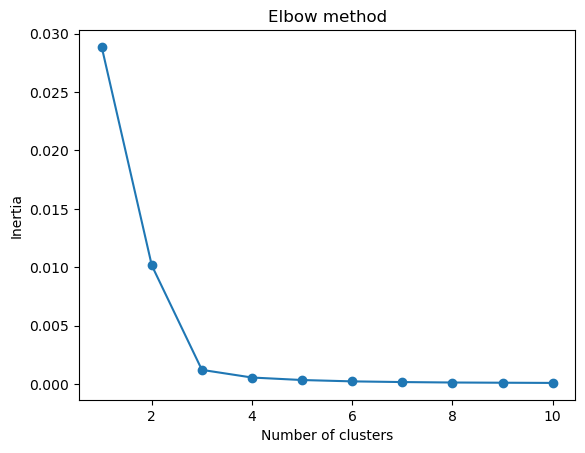

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0]


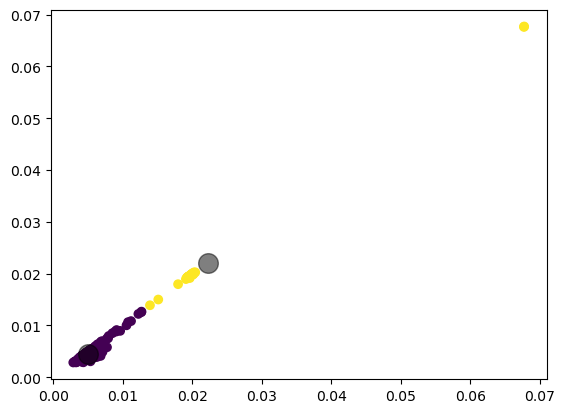

In [38]:
data = df[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

04-64139_ROB_1_axis1_MCC.txt
2017-09-20
04-64139_ROB_1_axis2_MCC.txt
2017-09-20
04-64139_ROB_1_axis3_MCC.txt
2017-09-20
04-64139_ROB_1_axis4_MCC.txt
2017-09-20
04-64139_ROB_1_axis5_MCC.txt
2017-09-20
04-64139_ROB_1_axis6_MCC.txt
2017-09-20


<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

<Figure size 1000x200 with 0 Axes>

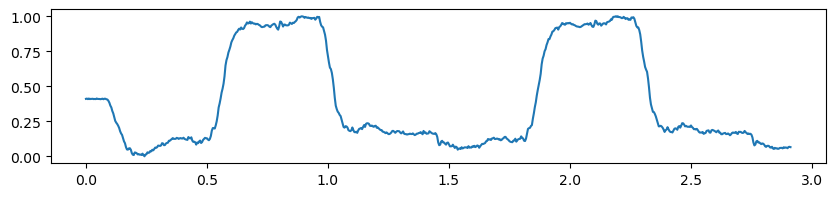

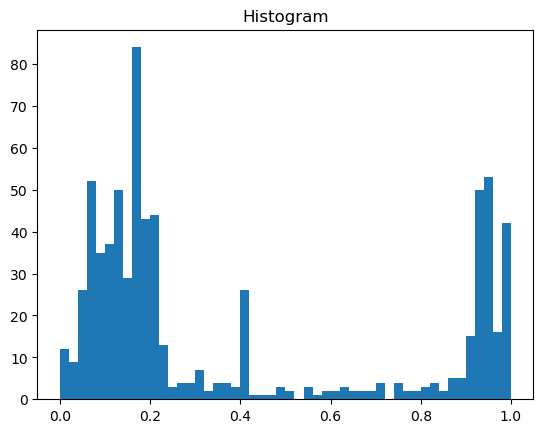

In [50]:
File_test = '04-64139_DIAGDATA_20170920_180212__MCC.zip'
feature_list_axis1 = []

from datetime import timedelta
with ZipFile(File_test) as File:
    for file in File.namelist():
        print(file)
        with File.open(file) as f:
            header = read_header(f)
            date = header['date_time']
            print(date.date())
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            plt.figure(figsize=(10,2)) 
            if ax2 in file:
                    # Extract features for axis1
                d = series.normalized_torque()            
                time_index = series.time_index
                   

plt.plot(time_index, d)
plt.show()
plt.hist(d, bins=50)
plt.title('Histogram')
from sklearn.neighbors import KernelDensity




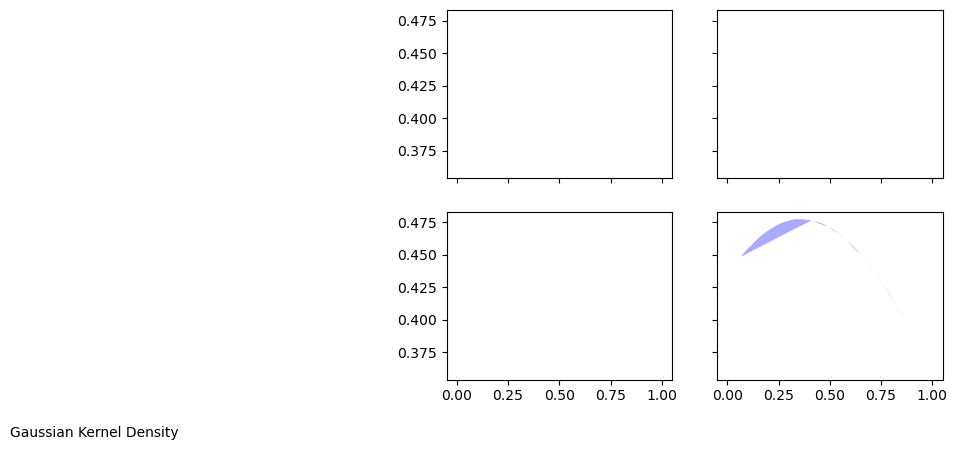

In [60]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
dd = d.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(dd)
log_dens = kde.score_samples(dd)
ax[1, 1].fill(dd[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")
plt.show()



In [ ]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
divergence_kullbackleibler = pd.DataFrame(columns=columns)
conditional_entropy = pd.DataFrame(columns=columns)
entropy = pd.DataFrame(columns=columns)
mutual_information = pd.DataFrame(columns=columns)
Jensen_Shannon_divergence = pd.DataFrame(columns=columns)
i = 0    
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    if '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' in route:
        ref1,ref2,ref3,ref4,ref5,ref6 = find_reference_point(route)
    else:
        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        DATA1 = series.normalized_torque()
                        print(ref1)
                        divergence_kullbackleibler.loc[i, 'axis1'] = drv.entropy_conditional(ref1,DATA1)
                        break
#                         Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1)
#                         Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1)
#                         Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
#                     elif ax2 in file:
#                     # Extract features for axis1
#                         DATA2 = series.torque
#                         d2 = np.concatenate((d2,DATA2), axis=None)
#                         RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                         Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2)
#                         Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2)
#                         Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                     elif ax3 in file:
#                     # Extract features for axis1
#                         DATA3 = series.torque
#                         d3 = np.concatenate((d3,DATA3), axis=None)
#                         RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                         Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3)
#                         Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3)
#                         Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                     elif ax4 in file:
#                     # Extract features for axis1
#                         DATA4 = series.torque
#                         d4 = np.concatenate((d4,DATA4), axis=None)
#                         RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                         Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4)
#                         Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4)
#                         Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                     elif ax5 in file:
#                     # Extract features for axis1
#                         DATA5 = series.torque
#                         d5 = np.concatenate((d5,DATA5), axis=None)
#                         RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                         Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5)
#                         Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5)
#                         Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                     elif ax6 in file:
#                     # Extract features for axis1
#                         DATA6 = series.torque
#                         d6 = np.concatenate((d6,DATA6), axis=None)
#                         RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#                         Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6)
#                         Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6)
#                         Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#             i = i + 1
               

In [ ]:
A = DATA1-ref1
A

In [ ]:
np.sum(rel_entr(DATA1,ref1))


In [ ]:
plt.figure(figsize=(10,2))
plt.plot(DATA1)
plt.plot(ref1)
# drv.entropy_conditional(ref1, DATA1)

In [ ]:
len(DATA1)